In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from IPython.core.pylabtools import figsize
from scipy.stats import zscore
from scipy import stats
from numpy import percentile

%matplotlib inline
%config InlineBackend.figure_format ='retina'
from pylab import rcParams

from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score

# Features explanation

## 1 - BI-RADS (Breast Imaging-Reporting and Data System) is a risk assessment and quality assurance tool developed by American College of Radiology that provides a widely accepted lexicon and reporting schema for imaging of the breast
### BI-RADS 0: incomplete
### BI-RADS 1: negative = 1.0
### BI-RADS 2: benign = 2.0
### BI-RADS 3: probably benign (<2% probability of malignancy) = 3.0
### BI-RADS 4: suspicious for malignancy (2-94% probability of malignancy(4A,4B,4C)) = 4.0
### BI-RADS 5: highly suggestive of malignancy (>95% probability of malignancy) = 5.0
### BI-RADS 6: known biopsy-proven malignancy 

## 2 - Shape (masses macroscopic view)
### oval = 1.0
### round = 2.0
### lobular = 3.0
### irregular = 4.0

## 3 - Margin (Macroscopic view)
### circumscribed = 1.0
### obscured = 2.0
### microlobulated (associated with malignancy) = 3.0
### indistinct (associated with malignancy) = 4.0
### spiculated (associated with malignancy) =5.0

## 4 - Density
### high density (over %78 are malignant) = 1.0
### equal density = 2.0
### low density = 3.0
### fat-containing (almost always benign) = 4.0

## 5 - Age (over 50 yo risk is high)

In [2]:
df=pd.read_csv('mammography.csv', na_values="?")

In [3]:
df.head()

,5,67,3,5.1,3.1,1
0,4.0,43.0,1.0,1.0,NaN,1
1,5.0,58.0,4.0,5.0,3.0,1
2,4.0,28.0,1.0,1.0,3.0,0
3,5.0,74.0,1.0,5.0,NaN,1
4,4.0,65.0,1.0,NaN,3.0,0


In [4]:
df.columns = ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Target']

In [5]:
df.tail()

,BI-RADS,Age,Shape,Margin,Density,Target
955,4.0,47.0,2.0,1.0,3.0,0
956,4.0,56.0,4.0,5.0,3.0,1
957,4.0,64.0,4.0,5.0,3.0,0
958,5.0,66.0,4.0,5.0,3.0,1
959,4.0,62.0,3.0,3.0,3.0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BI-RADS  958 non-null    float64
 1   Age      955 non-null    float64
 2   Shape    929 non-null    float64
 3   Margin   912 non-null    float64
 4   Density  884 non-null    float64
 5   Target   960 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 45.1 KB


In [7]:
df.shape

(960, 6)

In [8]:
df.isnull().sum()

BI-RADS     2
Age         5
Shape      31
Margin     48
Density    76
Target      0
dtype: int64

In [9]:
df['BI-RADS'].value_counts()

4.0     547
5.0     344
3.0      36
2.0      14
6.0      11
0.0       5
55.0      1
Name: BI-RADS, dtype: int64

In [10]:
df[df['BI-RADS']>=6.0]

,BI-RADS,Age,Shape,Margin,Density,Target
339,55.0,46.0,4.0,3.0,3.0,1
549,6.0,80.0,4.0,5.0,3.0,1
663,6.0,60.0,3.0,5.0,3.0,1
691,6.0,51.0,4.0,4.0,3.0,1
706,6.0,41.0,2.0,1.0,3.0,0
716,6.0,71.0,4.0,4.0,3.0,1
717,6.0,68.0,4.0,3.0,3.0,1
744,6.0,76.0,3.0,NaN,3.0,0
783,6.0,63.0,1.0,1.0,3.0,0
823,6.0,40.0,NaN,3.0,4.0,1


In [11]:
bool_series = pd.isnull(df["BI-RADS"])
df[bool_series]

,BI-RADS,Age,Shape,Margin,Density,Target
19,NaN,66.0,NaN,NaN,1.0,1
207,NaN,52.0,4.0,4.0,3.0,0


In [12]:
df.iloc[19,0]=5.0

In [13]:
df.iloc[339,0]=5.0

In [14]:
df.iloc[207,0]=1.0

In [15]:
df[bool_series]

,BI-RADS,Age,Shape,Margin,Density,Target
19,5.0,66.0,NaN,NaN,1.0,1
207,1.0,52.0,4.0,4.0,3.0,0


In [16]:
df.isnull().sum()

BI-RADS     0
Age         5
Shape      31
Margin     48
Density    76
Target      0
dtype: int64

In [17]:
bool_series = pd.isnull(df["Age"])
df[bool_series]

,BI-RADS,Age,Shape,Margin,Density,Target
442,4.0,NaN,4.0,5.0,3.0,1
452,5.0,NaN,4.0,4.0,3.0,1
682,5.0,NaN,3.0,3.0,3.0,1
883,5.0,NaN,4.0,4.0,3.0,1
922,5.0,NaN,4.0,3.0,3.0,1


In [18]:
df.iloc[442,1]=54.0
df.iloc[452,1]=55.0
df.iloc[682,1]=59.0
df.iloc[883,1]=57.0
df.iloc[922,1]=60.0

In [19]:
df[bool_series]

,BI-RADS,Age,Shape,Margin,Density,Target
442,4.0,54.0,4.0,5.0,3.0,1
452,5.0,55.0,4.0,4.0,3.0,1
682,5.0,59.0,3.0,3.0,3.0,1
883,5.0,57.0,4.0,4.0,3.0,1
922,5.0,60.0,4.0,3.0,3.0,1


In [20]:
bool_series = pd.isnull(df["Shape"])
df[bool_series]

,BI-RADS,Age,Shape,Margin,Density,Target
5,4.0,70.0,NaN,NaN,3.0,0
8,5.0,60.0,NaN,5.0,1.0,1
19,5.0,66.0,NaN,NaN,1.0,1
47,2.0,42.0,NaN,NaN,4.0,0
53,4.0,53.0,NaN,5.0,3.0,1
73,5.0,70.0,NaN,4.0,NaN,1
82,4.0,57.0,NaN,4.0,1.0,0
127,4.0,52.0,NaN,4.0,NaN,0
156,4.0,51.0,NaN,NaN,3.0,0
162,4.0,53.0,NaN,4.0,3.0,0


In [21]:
df.Shape.value_counts()

4.0    400
1.0    224
2.0    211
3.0     94
Name: Shape, dtype: int64

In [22]:
df.isnull().sum()

BI-RADS     0
Age         0
Shape      31
Margin     48
Density    76
Target      0
dtype: int64

In [23]:
df.Density.value_counts()

3.0    797
2.0     59
1.0     16
4.0     12
Name: Density, dtype: int64

In [24]:
bool_series = pd.isnull(df["Density"])
df[bool_series]

,BI-RADS,Age,Shape,Margin,Density,Target
0,4.0,43.0,1.0,1.0,NaN,1
3,5.0,74.0,1.0,5.0,NaN,1
18,4.0,40.0,1.0,NaN,NaN,0
21,4.0,43.0,1.0,NaN,NaN,0
25,2.0,66.0,1.0,1.0,NaN,0
...,...,...,...,...,...,...
613,3.0,46.0,NaN,5.0,NaN,1
626,4.0,57.0,2.0,1.0,NaN,0
664,4.0,27.0,2.0,1.0,NaN,0
676,4.0,57.0,4.0,4.0,NaN,1


In [25]:
df[bool_series]['Target'].value_counts()

0    54
1    22
Name: Target, dtype: int64

In [26]:
df['Density'].fillna(3.0, inplace=True) # %71 of density is benign

In [27]:
df['Density'].value_counts()

3.0    873
2.0     59
1.0     16
4.0     12
Name: Density, dtype: int64

In [28]:
df.isnull().sum()
    

BI-RADS     0
Age         0
Shape      31
Margin     48
Density     0
Target      0
dtype: int64

In [29]:
df = df.dropna()

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 959
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BI-RADS  891 non-null    float64
 1   Age      891 non-null    float64
 2   Shape    891 non-null    float64
 3   Margin   891 non-null    float64
 4   Density  891 non-null    float64
 5   Target   891 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 48.7 KB


## EDA

In [31]:
df.describe()

,BI-RADS,Age,Shape,Margin,Density,Target
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,4.312009,55.417508,2.750842,2.767677,2.921437,0.474747
std,0.694490,14.616625,1.242816,1.568263,0.339366,0.499642
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,6.000000,96.000000,4.000000,5.000000,4.000000,1.000000


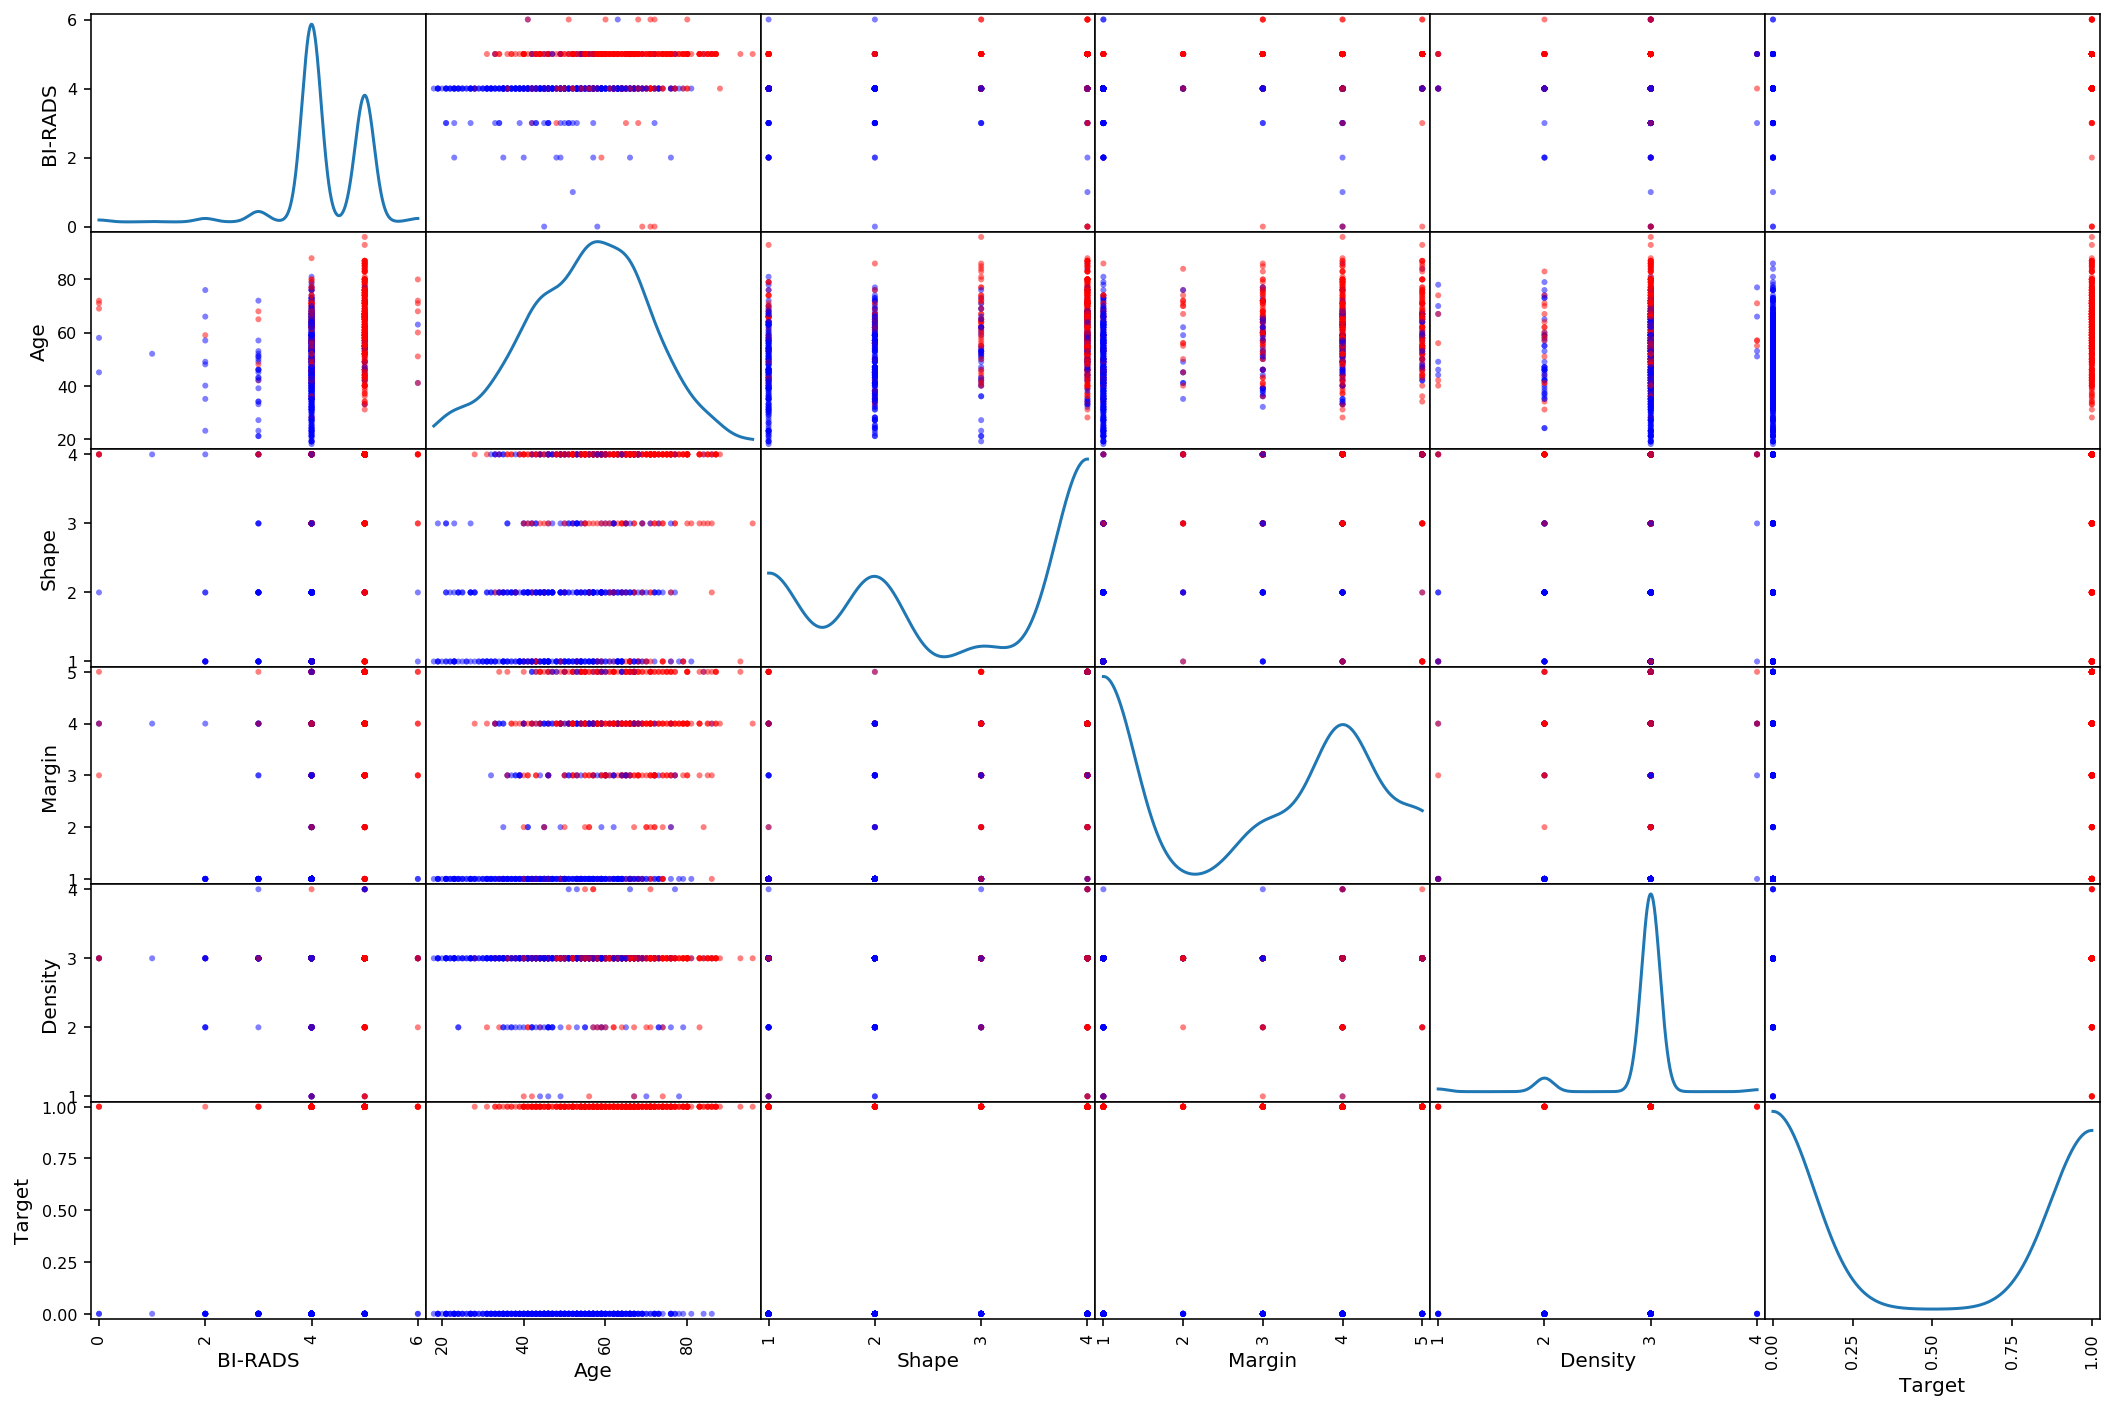

In [32]:
color_dict = {0:'blue', 1:'red'}
# map each row to a color based on the class value 
colors = [color_dict[(x)] for x in df.values[:, -1]] 
    # pairwise scatter plots of all numerical variables 
_ = scatter_matrix(df, diagonal='kde', color=colors,figsize=(18,12)) 
_ = plt.show()

In [33]:
rcParams['figure.figsize'] = 15, 12

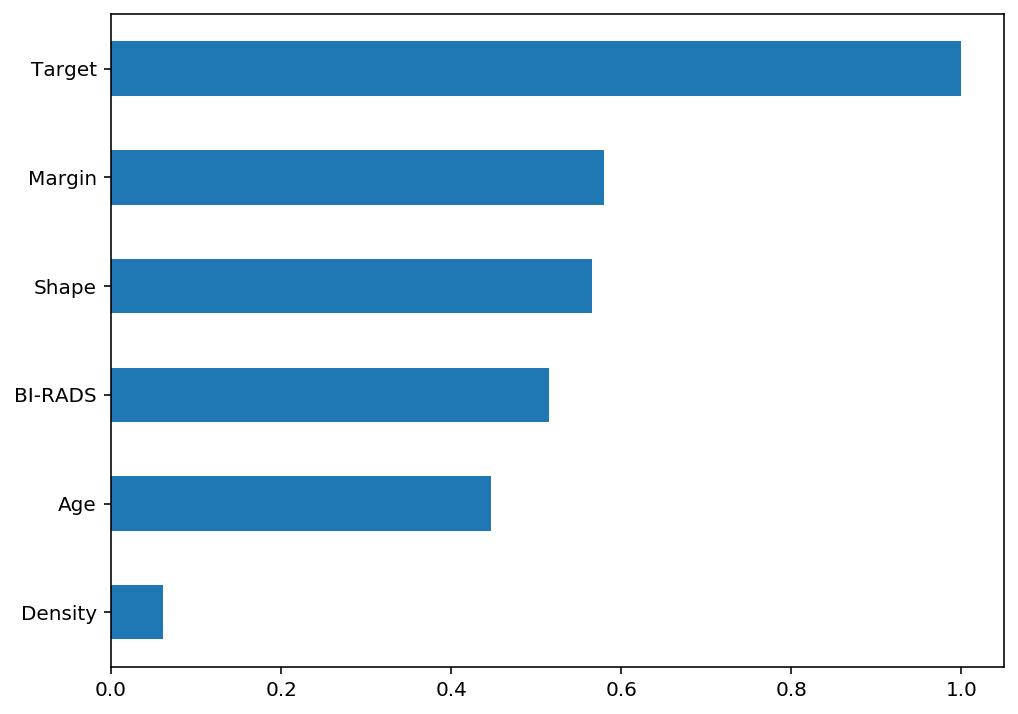

In [34]:
df.corr()['Target'].sort_values().plot.barh(figsize=(8,6));

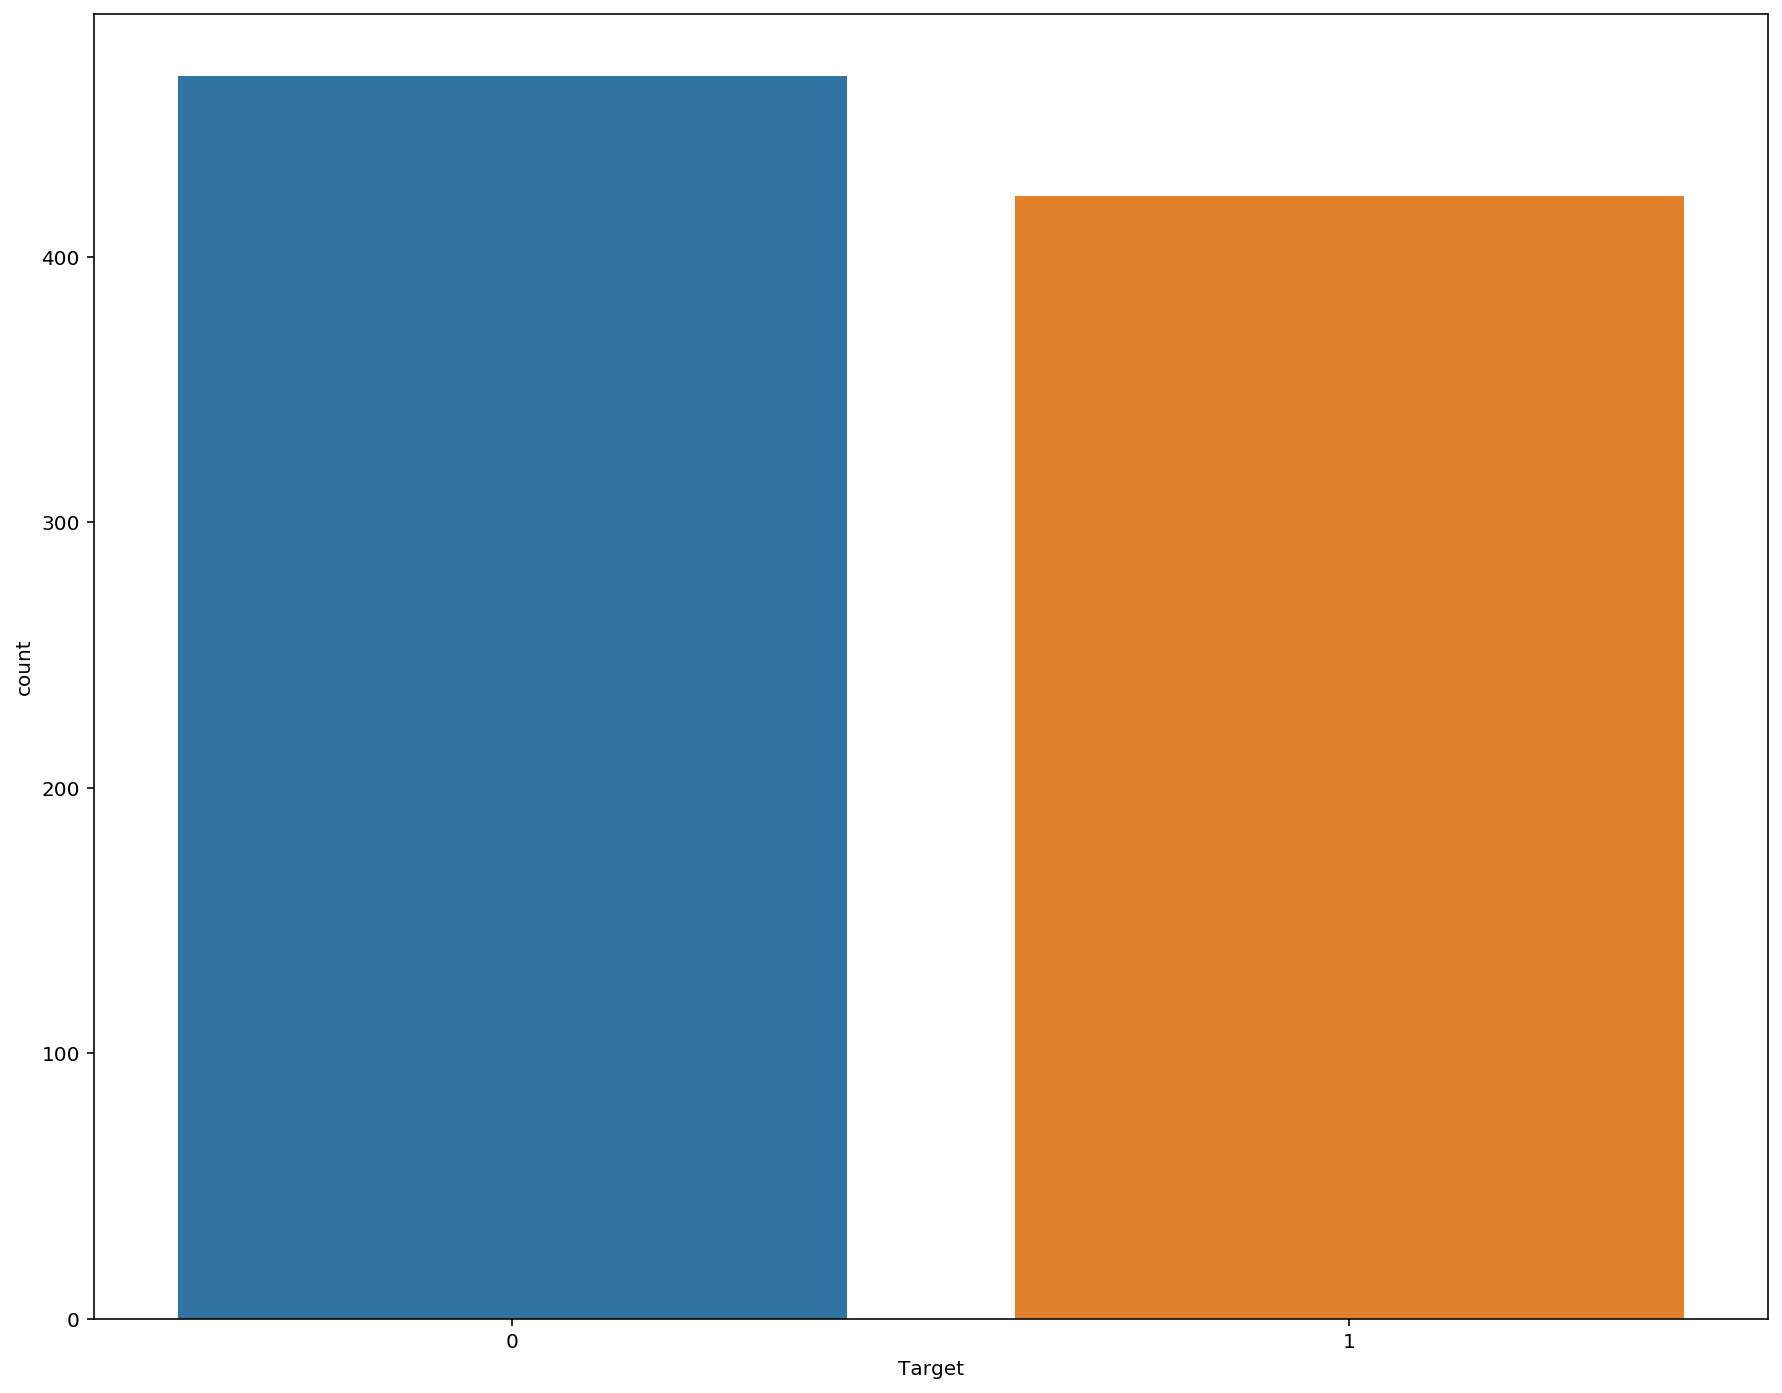

In [35]:
sns.countplot(x='Target', data = df);

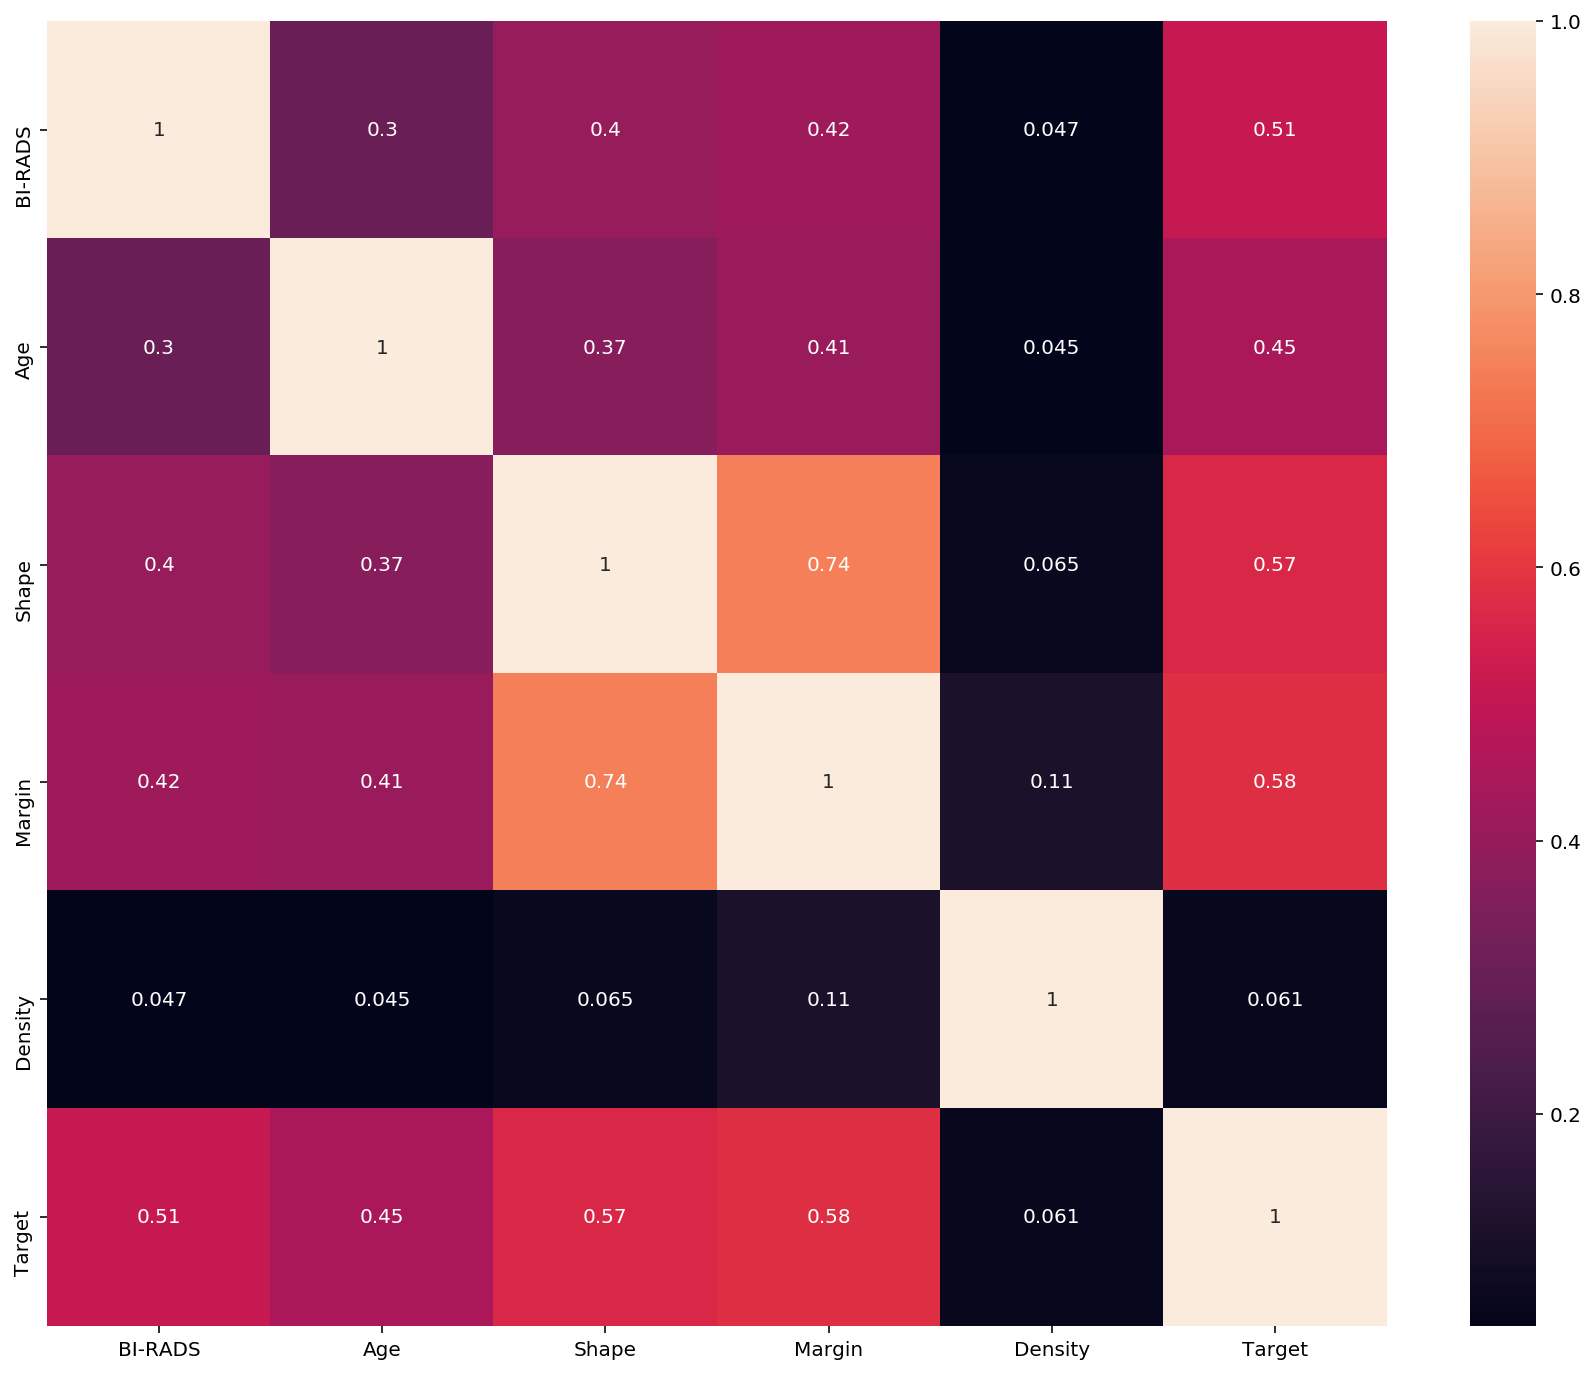

In [36]:
sns.heatmap(df.corr(), annot = True);

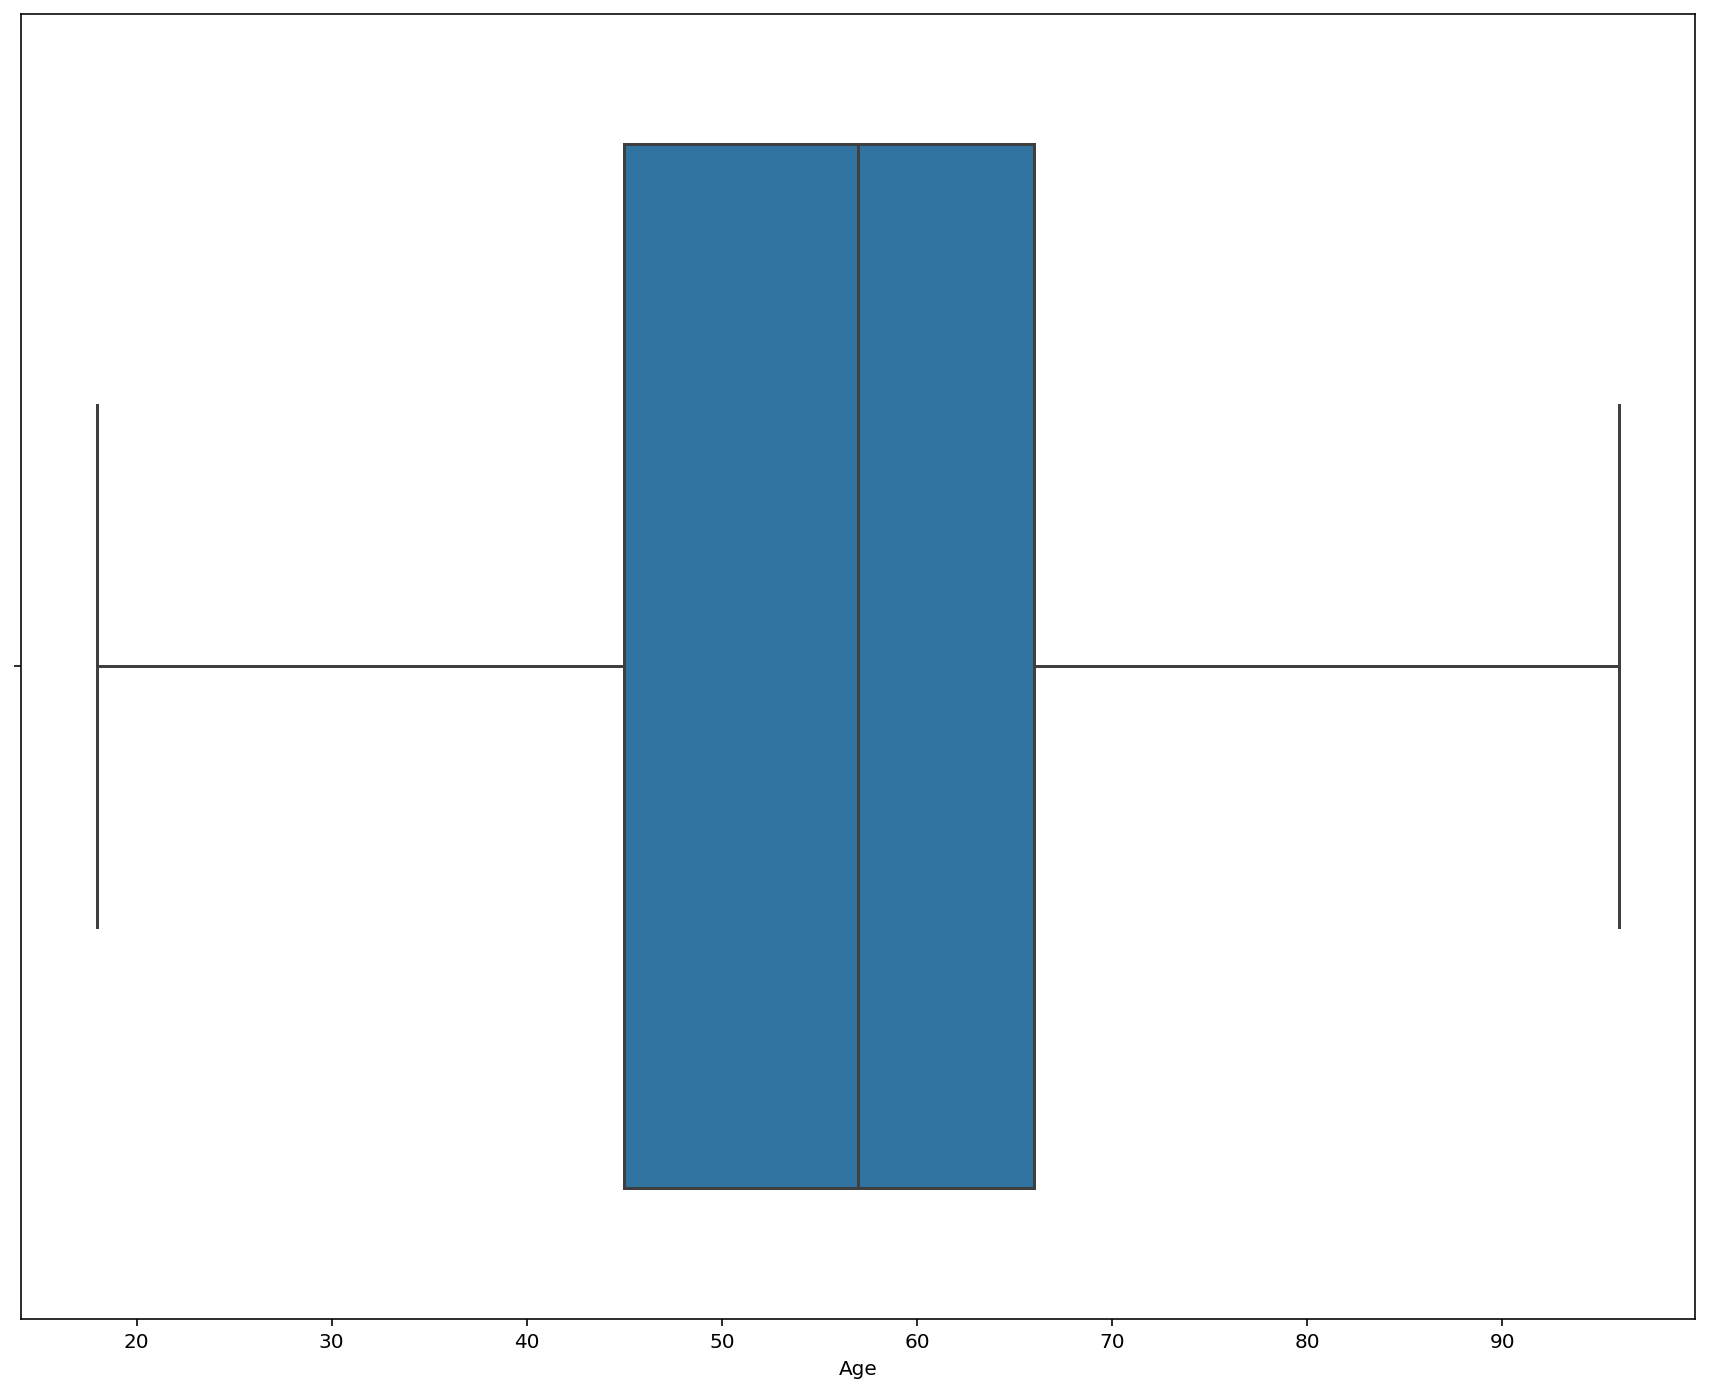

In [37]:
sns.boxplot(x=df.Age);

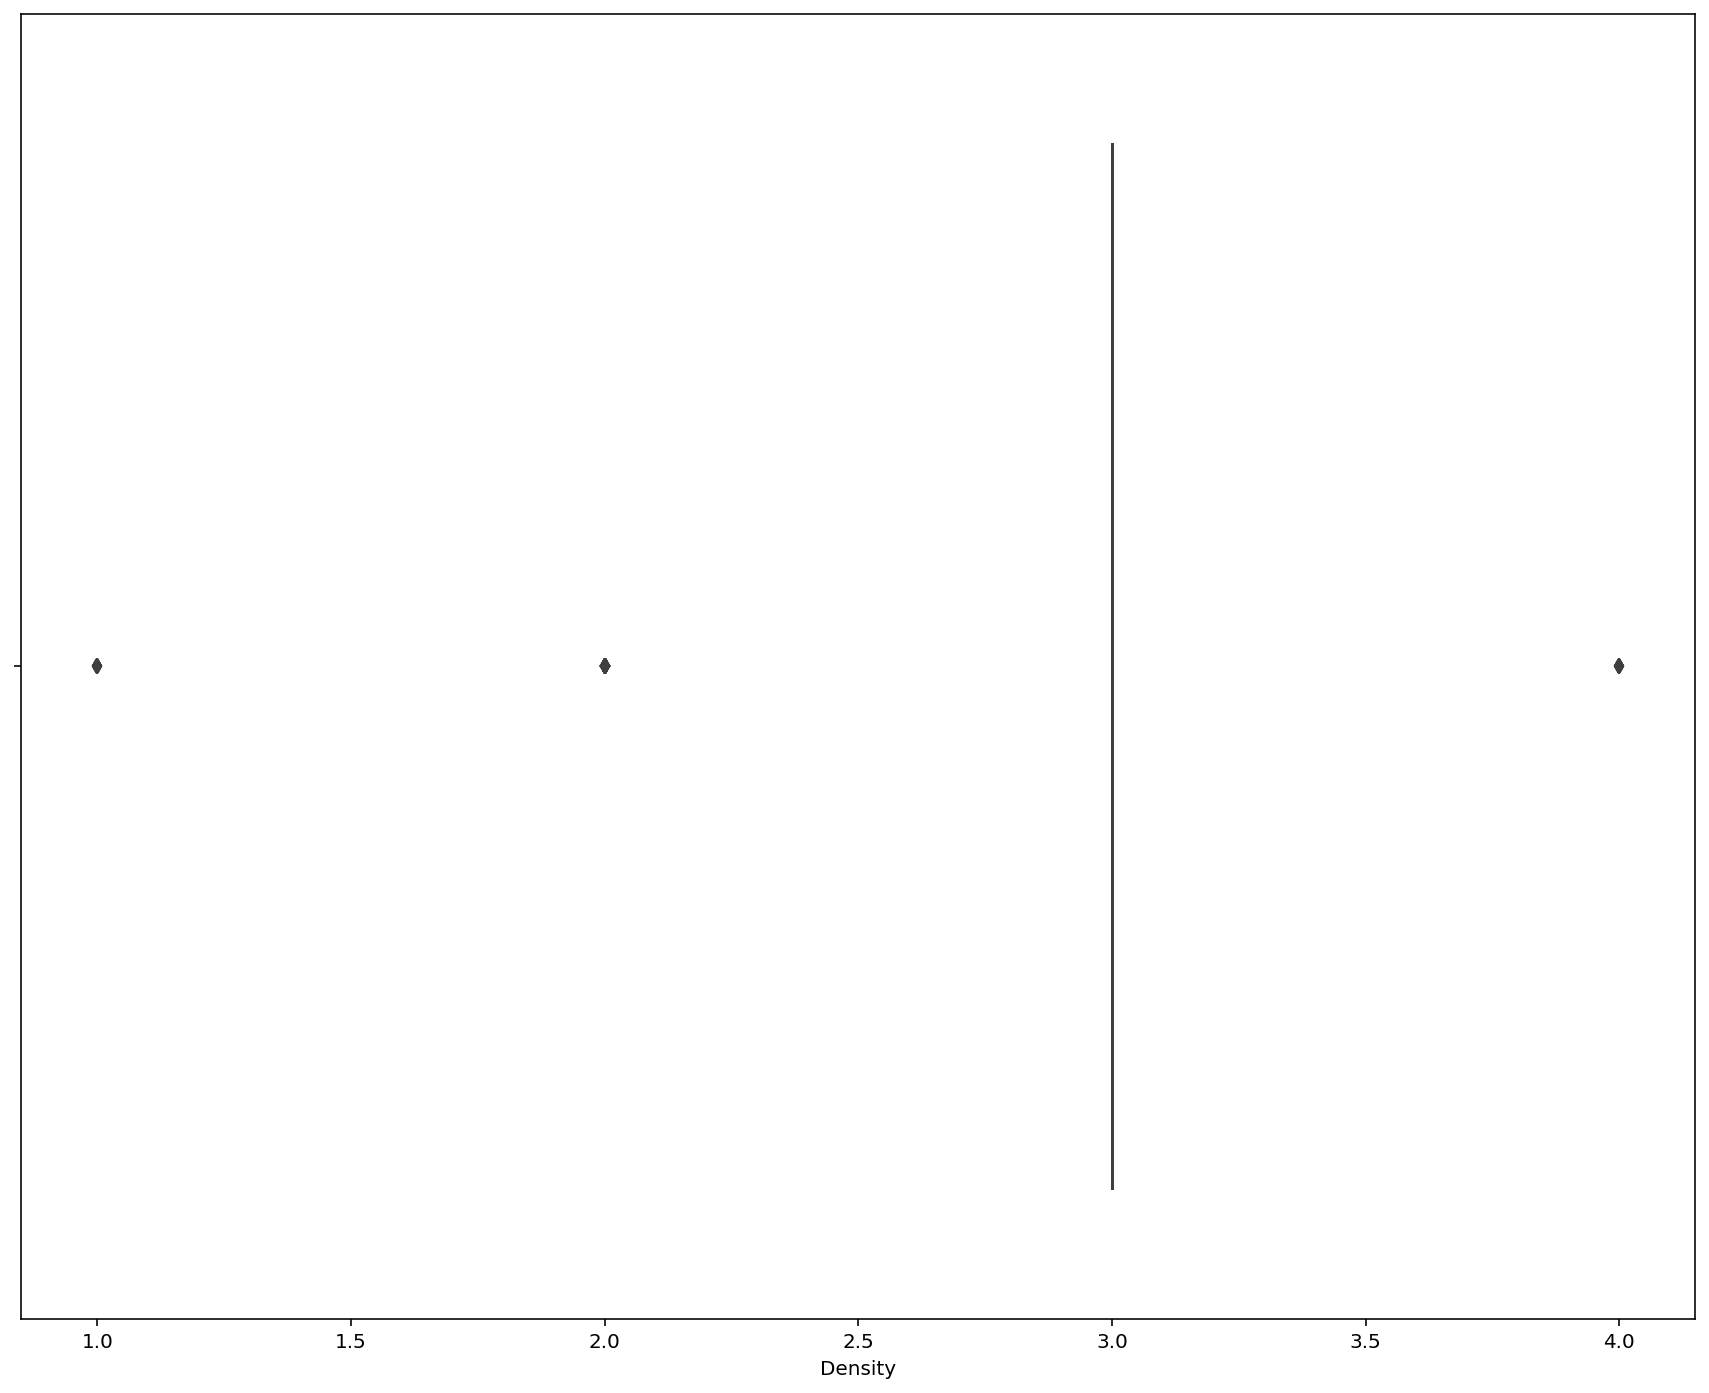

In [38]:
sns.boxplot(x=df.Density);

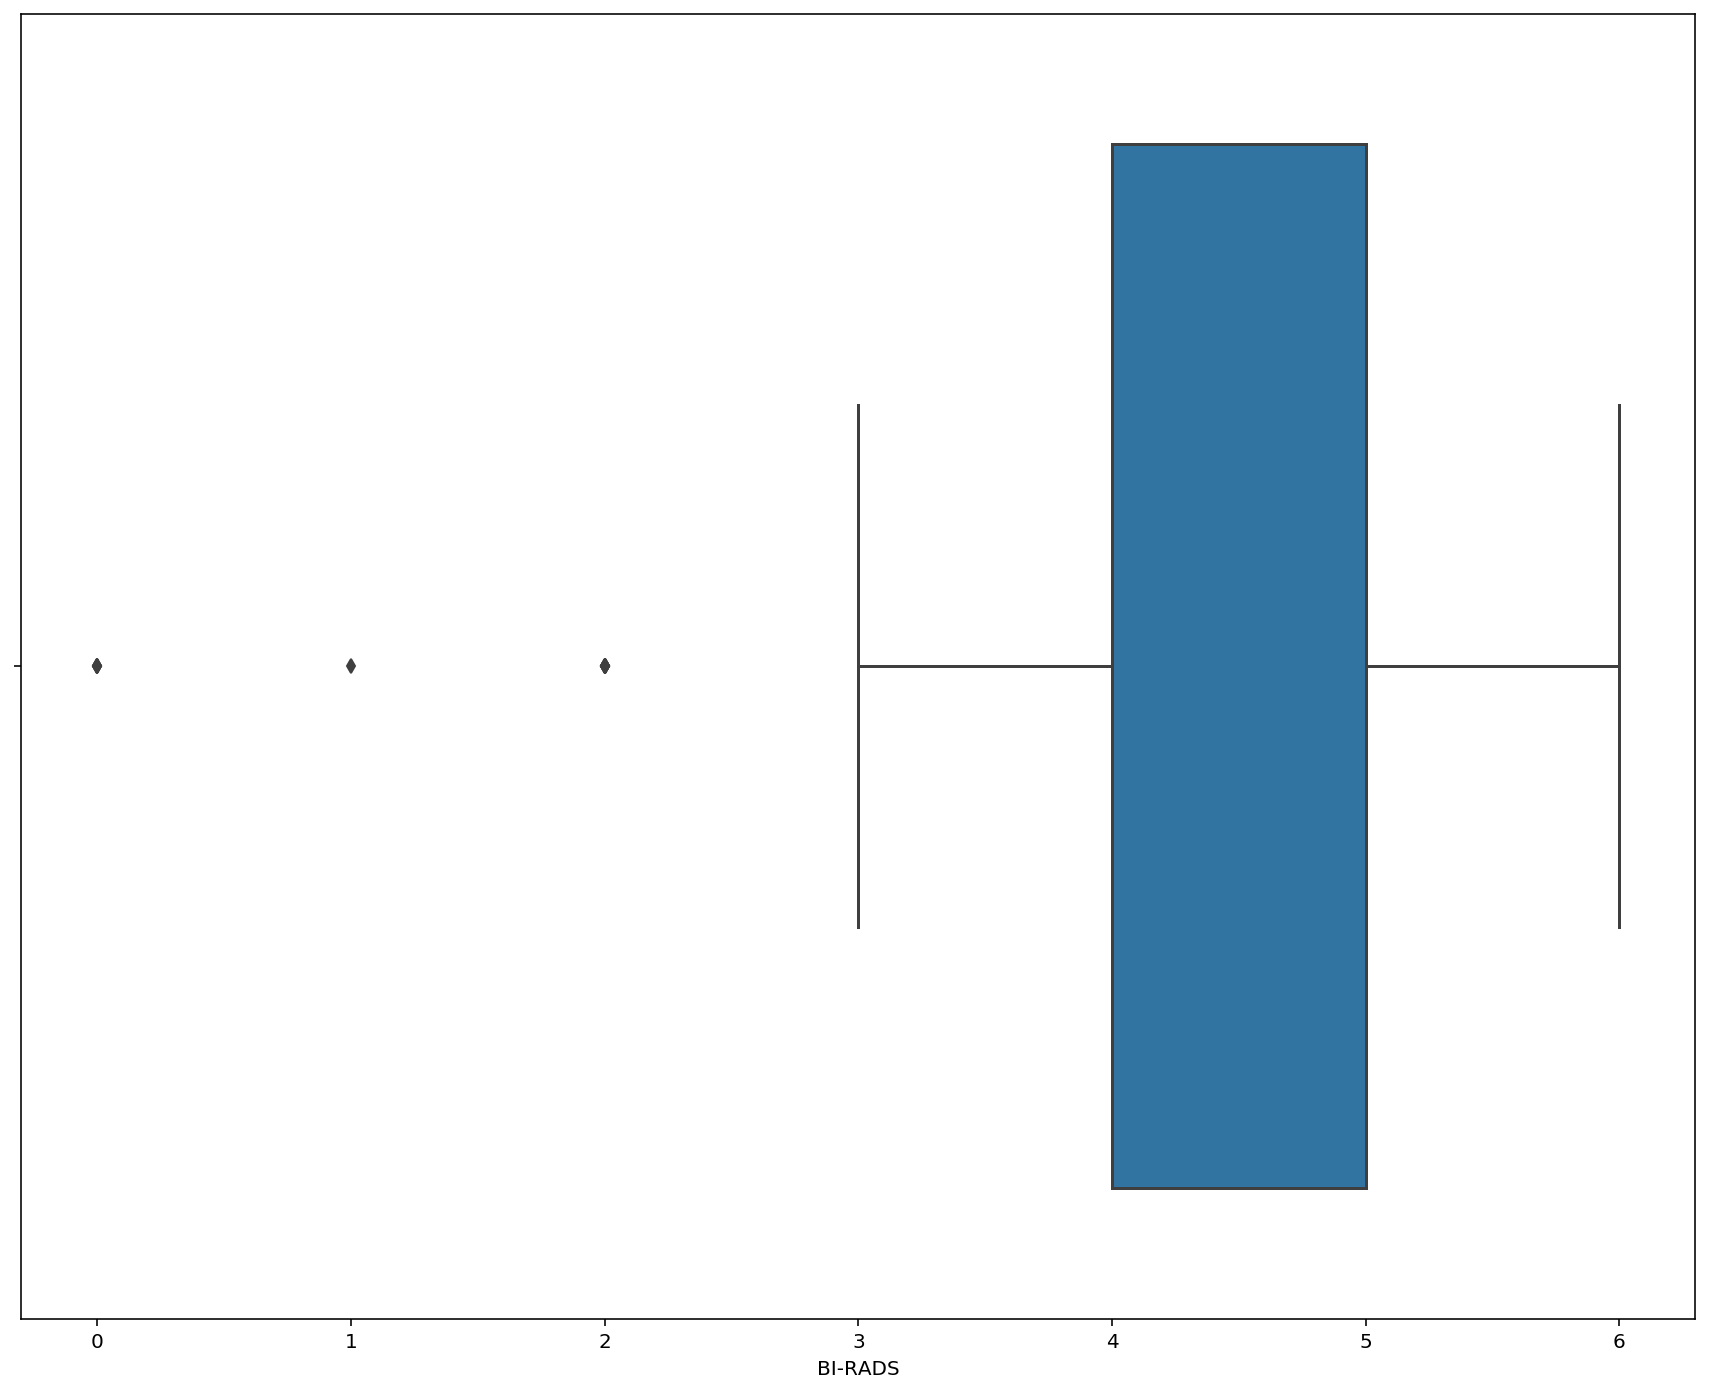

In [39]:
sns.boxplot(x=df['BI-RADS']);

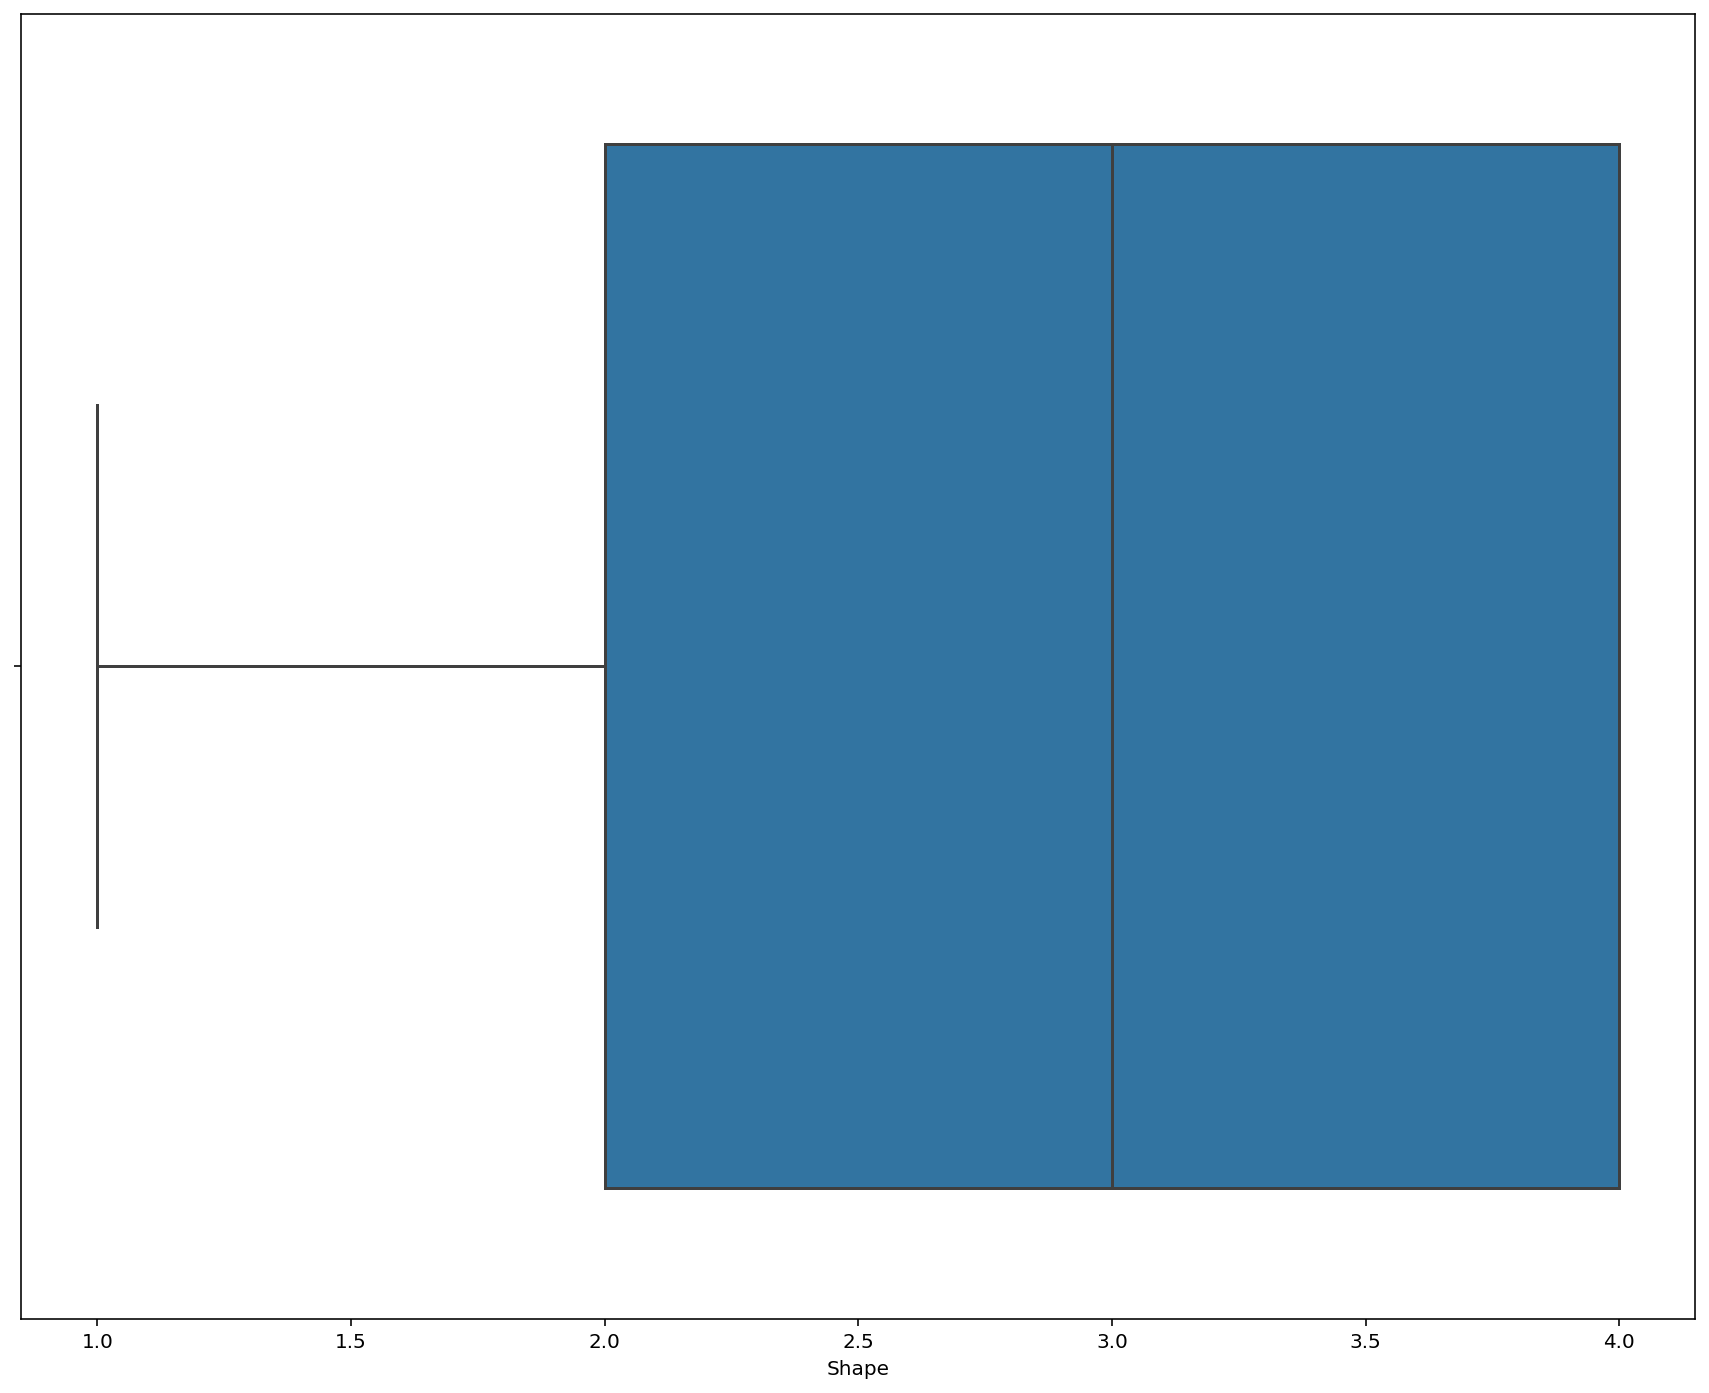

In [40]:
sns.boxplot(x=df['Shape']);

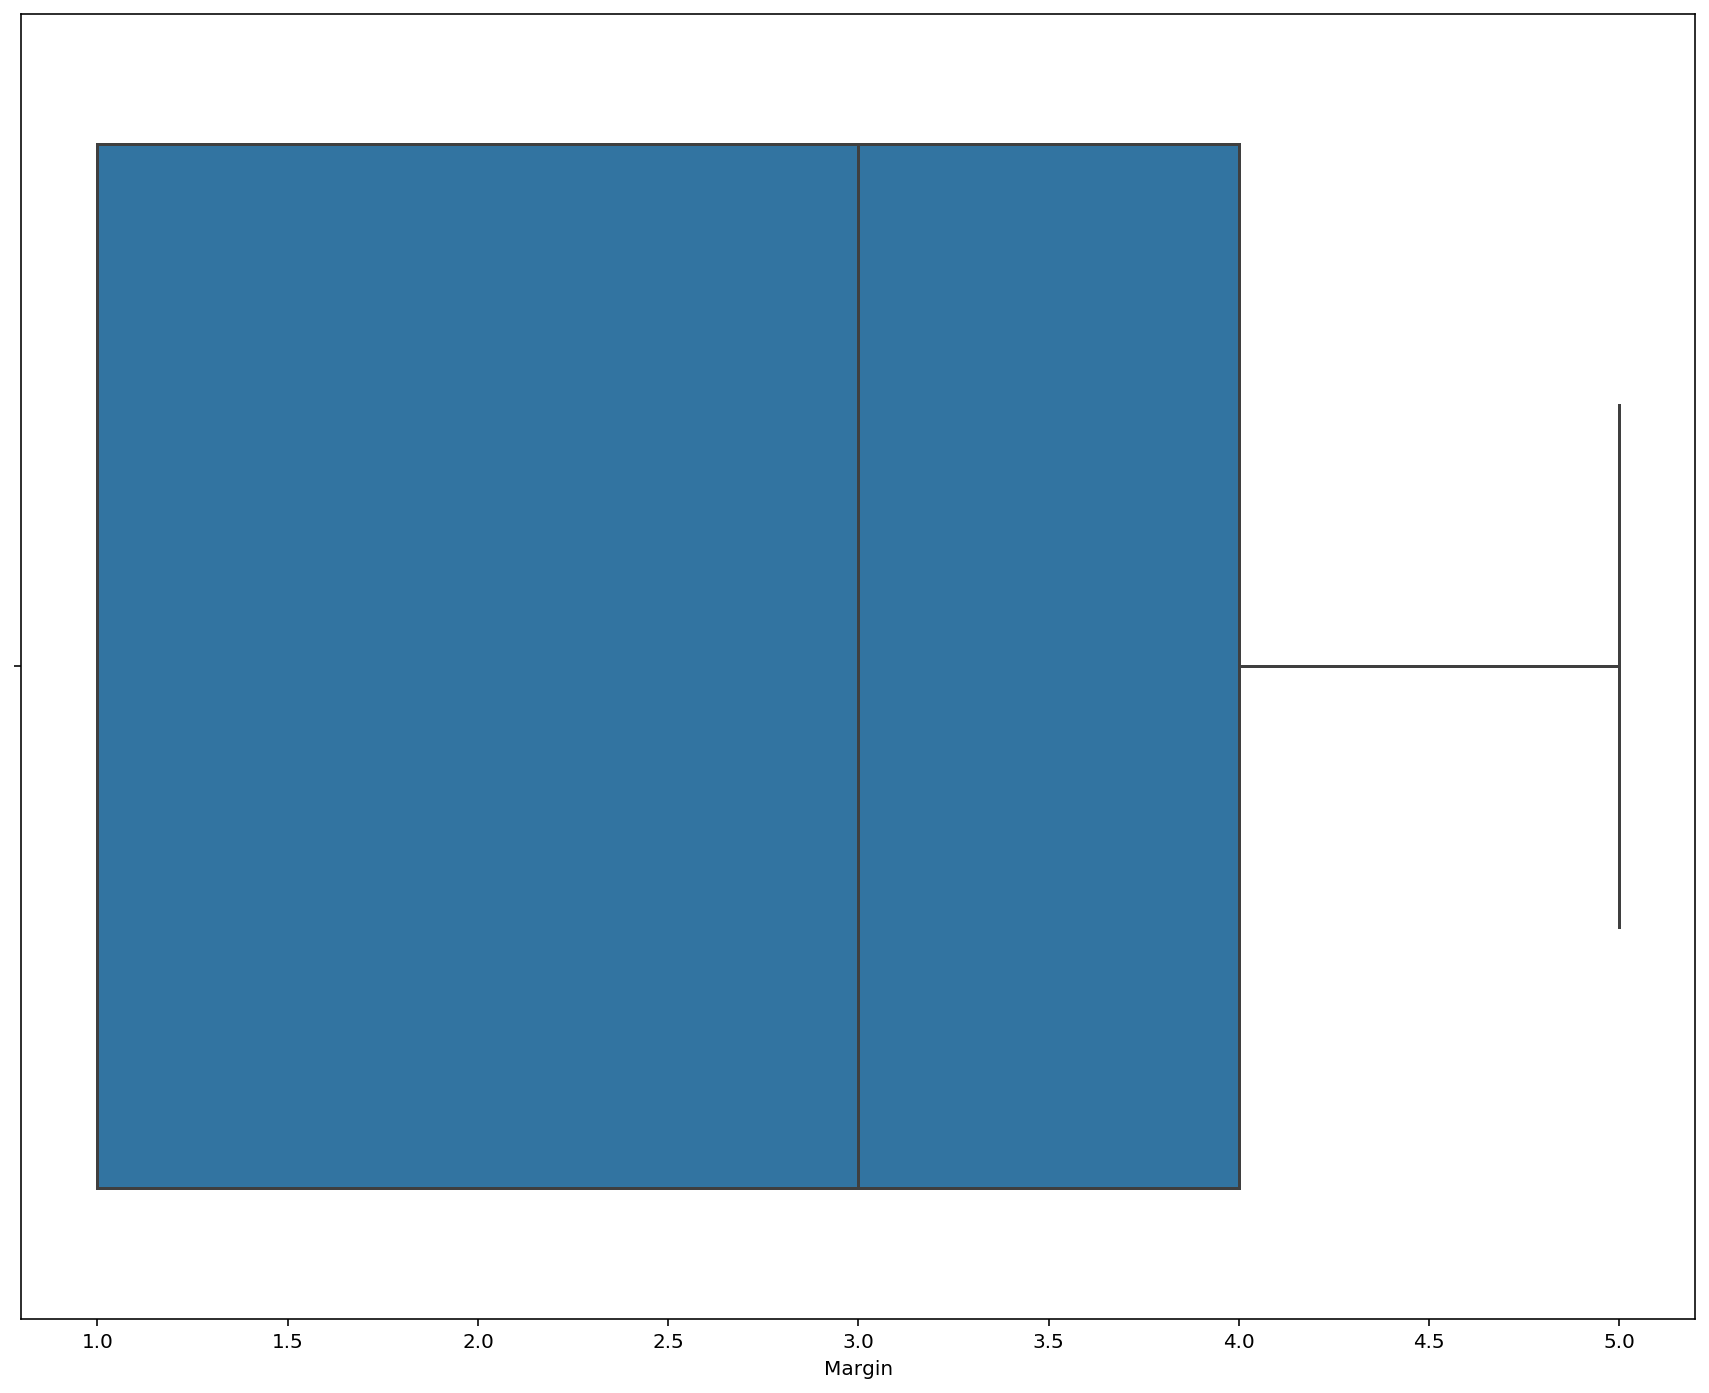

In [41]:
sns.boxplot(x=df['Margin']);

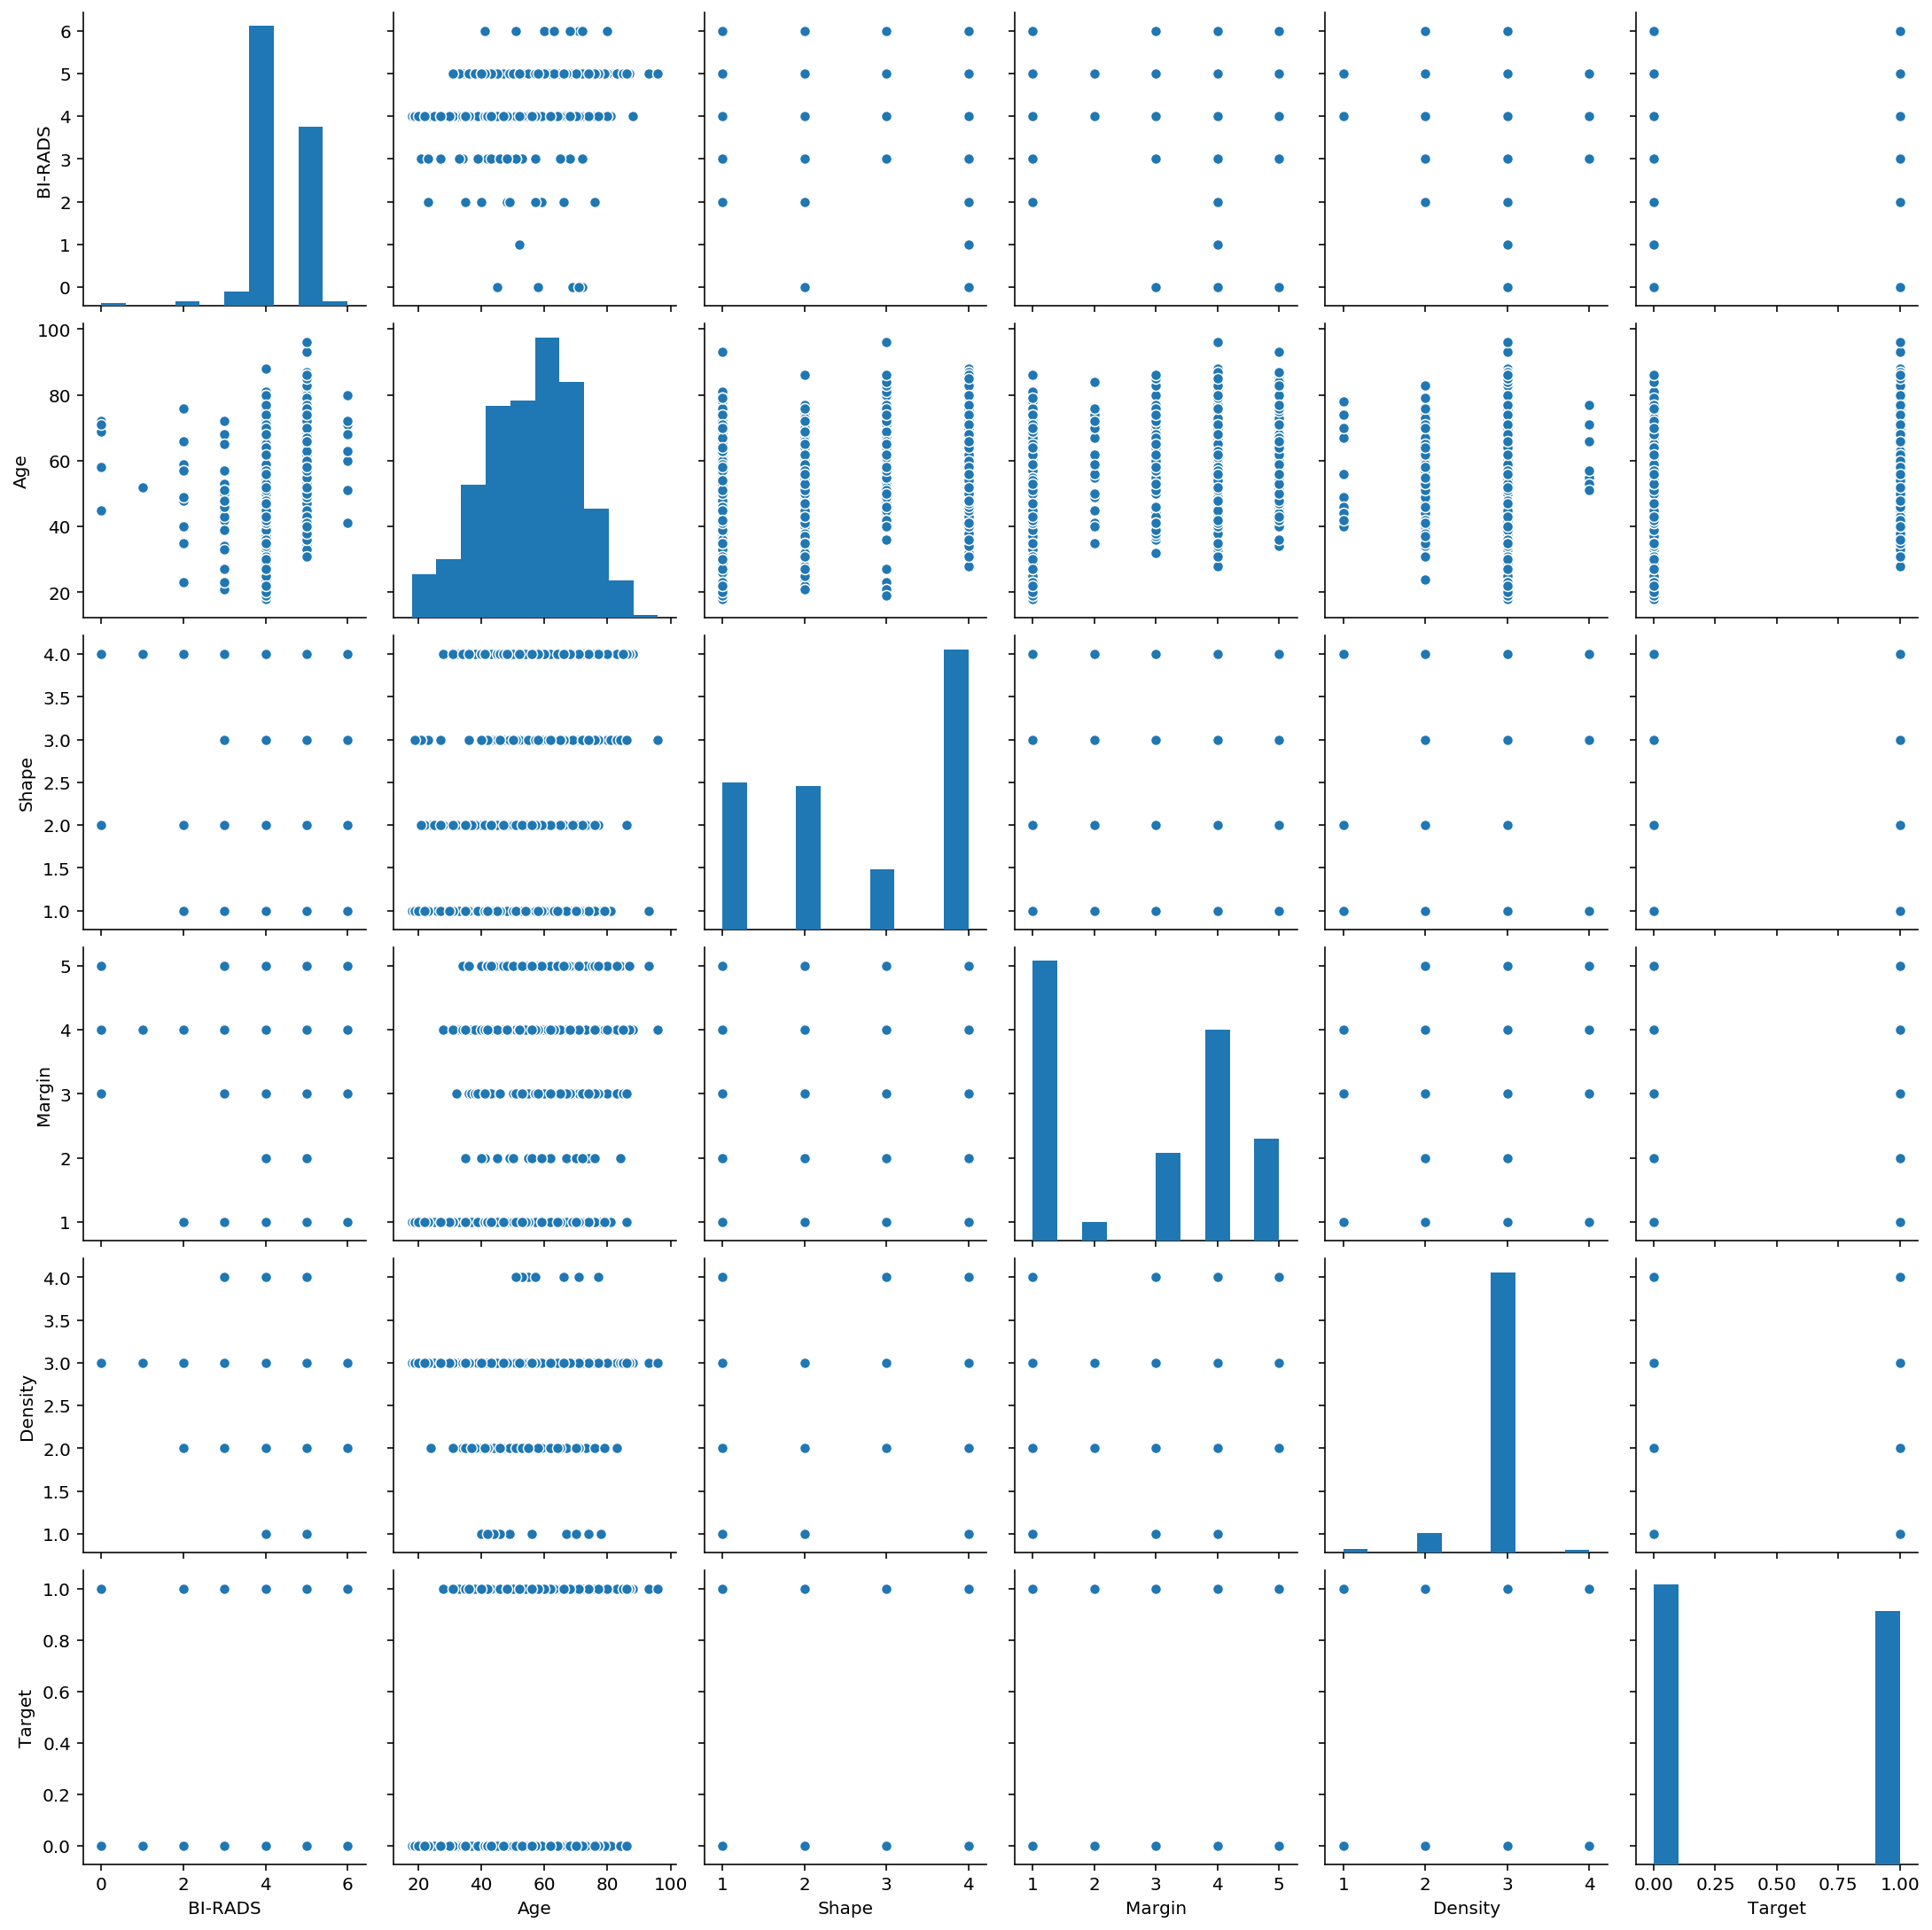

In [91]:
sns.pairplot(data=df)

# Train-Test_Split

In [42]:
X = df.drop("Target",axis=1)
y = df["Target"]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## LogisticRegression

In [44]:
logreg=LogisticRegression()

In [45]:
logreg.fit(X_train,y_train)

LogisticRegression()

In [46]:
y_pred=logreg.predict(X_test)

In [47]:
logreg_f1 = f1_score(y_test, y_pred, average='macro')
logreg_f1

0.8374816067123759

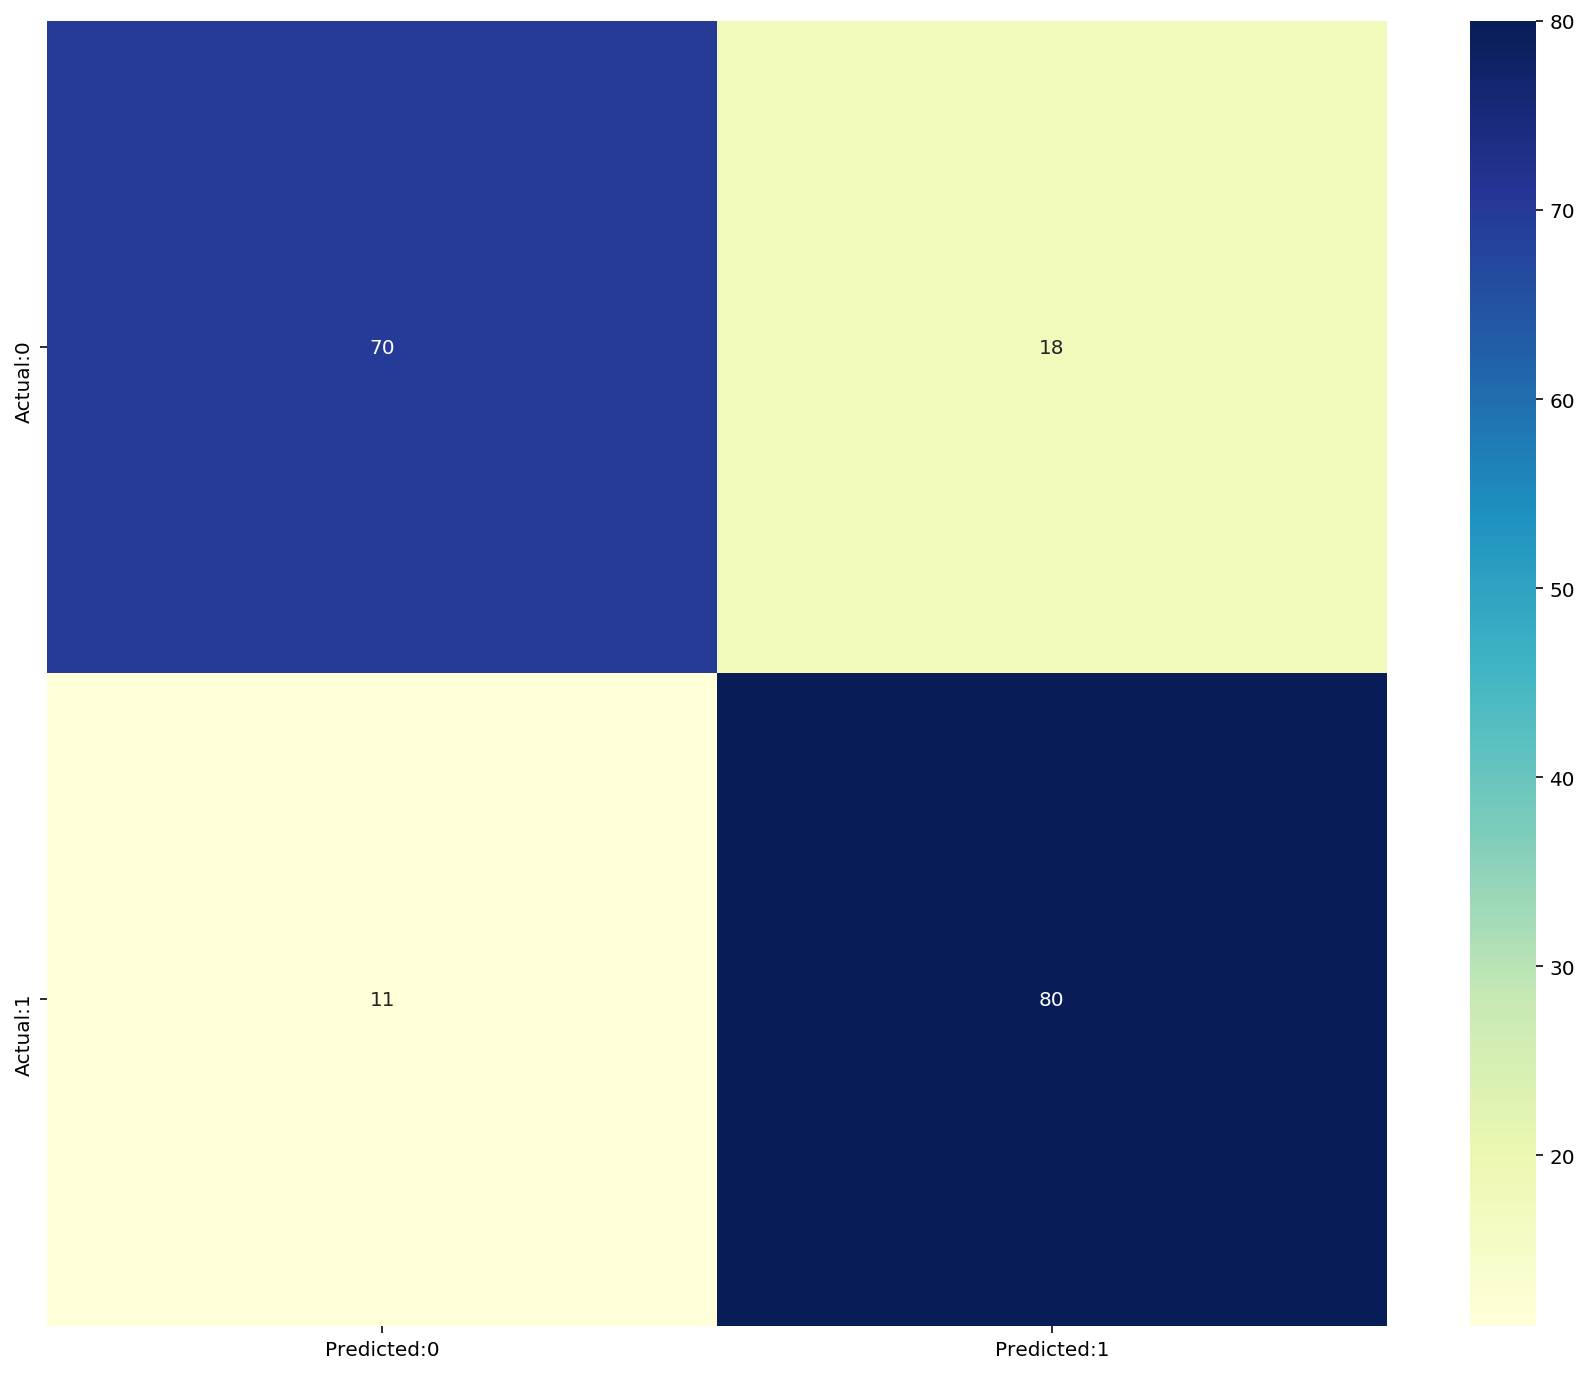

In [48]:
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        88
           1       0.82      0.88      0.85        91

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179



## XGBoost (with tuning)

In [50]:
xgb = XGBClassifier()

In [51]:
xgb_params = {"n_estimators": [50, 100, 300],
             "subsample":[0.5,0.8,1],
             "max_depth":[3,5,7],
             "learning_rate":[0.1,0.01,0.3]}

In [52]:
xgb_cv_model = GridSearchCV(xgb, xgb_params, cv = 2, 
                            n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


In [53]:
xgb_cv_model.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}

In [54]:
xgb_tuned = XGBClassifier(learning_rate= 0.01, 
                                max_depth= 3, 
                                n_estimators= 100, 
                                subsample= 0.5).fit(X_train, y_train)

In [55]:
y_pred = xgb_tuned.predict(X_test)

In [56]:
xgb_f1 = f1_score(y_test, y_pred, average='macro')
xgb_f1

0.8156424581005587

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82        88
           1       0.83      0.80      0.82        91

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179



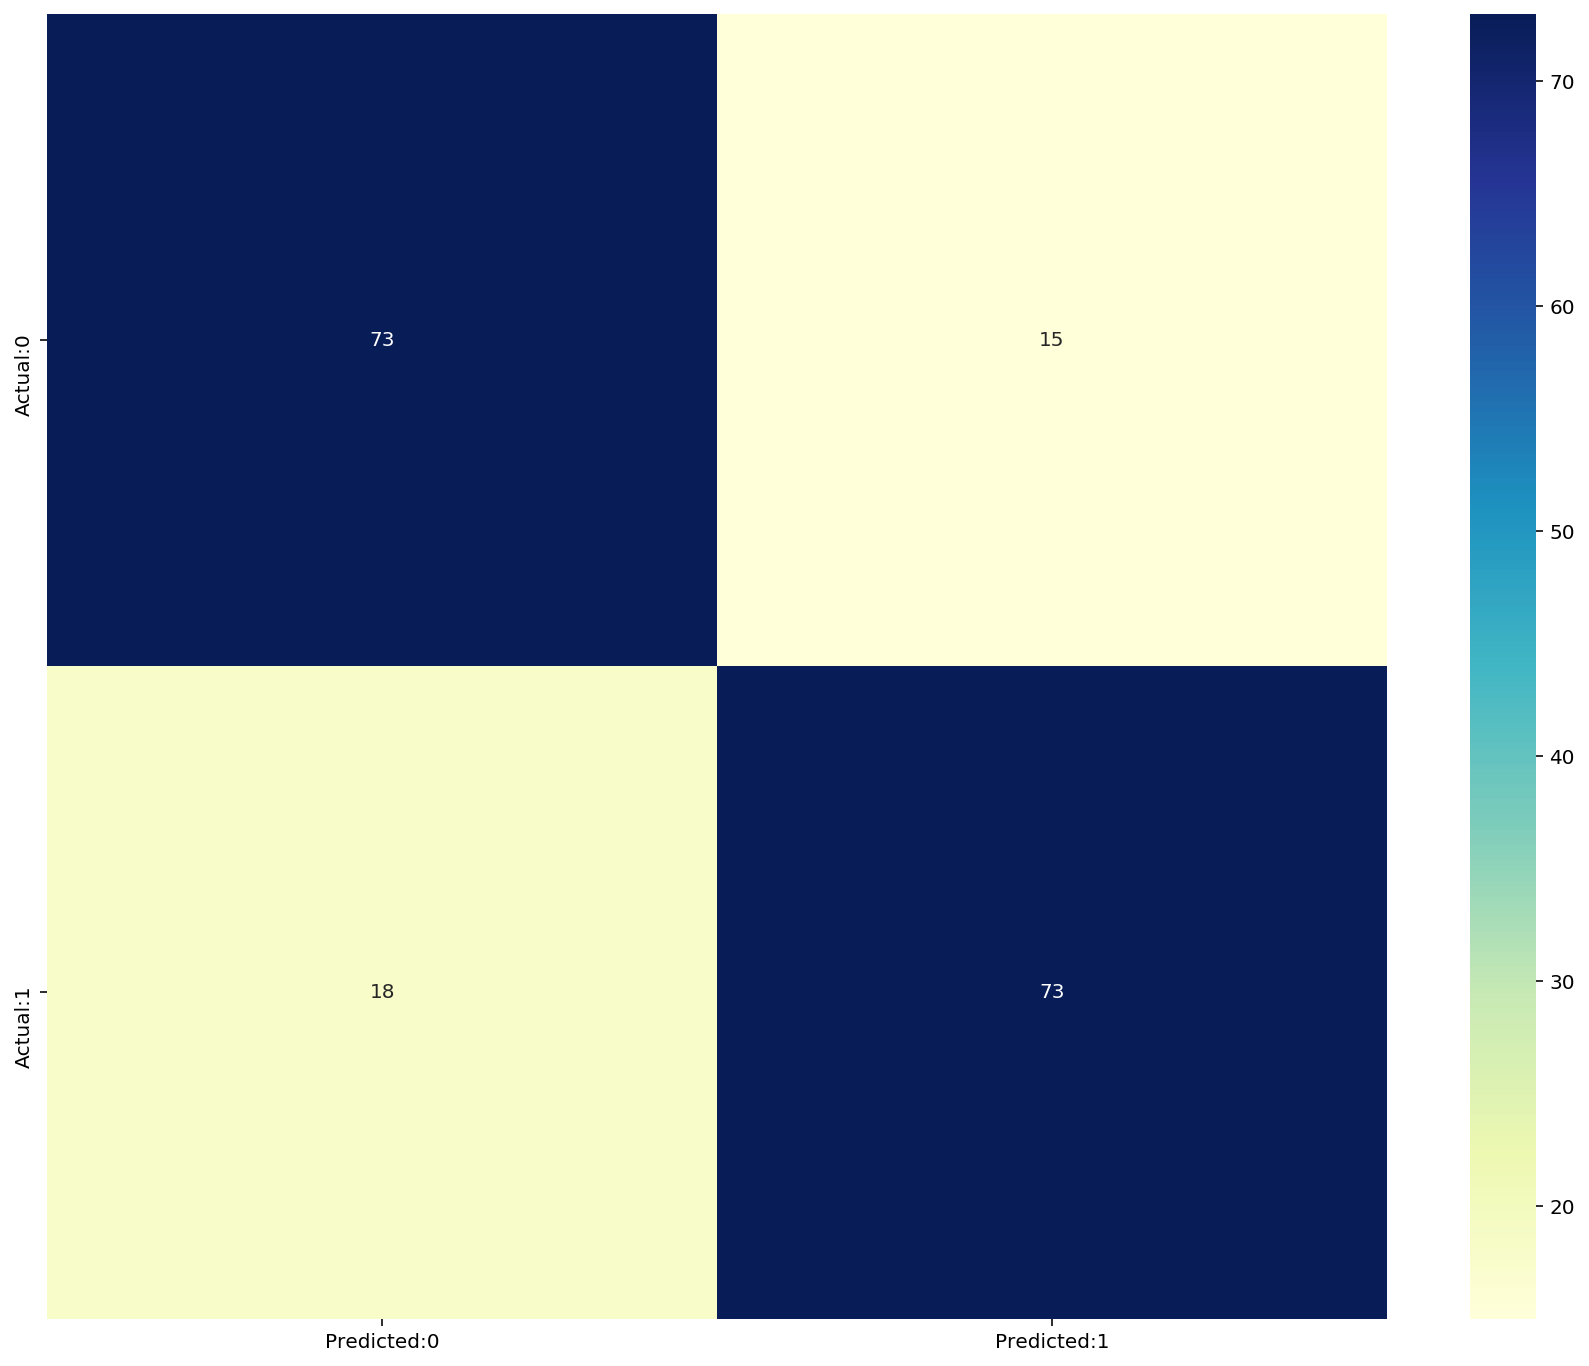

In [58]:
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

# RandomForest (with tuning)

In [59]:
rf_m = RandomForestClassifier()

In [60]:
rf_params = {"n_estimators":[50, 100, 300],
              "max_depth":[3,5,7],
              "max_features": [2,4,6,8],
              "min_samples_split": [2,4,6]}

In [61]:
rf_cv_model = GridSearchCV(rf_m, rf_params, cv = 5, n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.84415444 0.84557274 0.84556289 0.83713188 0.84413474 0.84556289
 0.84837979 0.84556289 0.84838964 0.84695164 0.85255589 0.84975869
 0.84834039 0.84273614 0.84694179 0.84554319 0.84975869 0.84974884
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.84557274 0.84557274 0.85258544 0.84416429 0.85259529 0.84696149
 0.85259529 0.84555304 0.84977839 0.85119669 0.84839949 0.84838964
 0.84977839 0.84559244 0.84839949 0.84979809 0.84697134 0.84836994
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.83999803 0.83718113 0.84419383 0.83998818 0.840017

In [62]:
rf_cv_model.best_params_

{'max_depth': 5,
 'max_features': 2,
 'min_samples_split': 4,
 'n_estimators': 100}

In [63]:
rf_tuned = RandomForestClassifier(max_depth = 5,             
                                  max_features = 2, 
                                  min_samples_split = 4, 
                                  n_estimators = 50).fit(X_train, y_train)

In [64]:
y_pred = rf_tuned.predict(X_test)

In [65]:
rf_f1 = f1_score(y_test, y_pred, average='macro')
rf_f1

0.8100024975024975

In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        88
           1       0.81      0.81      0.81        91

    accuracy                           0.81       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.81      0.81      0.81       179



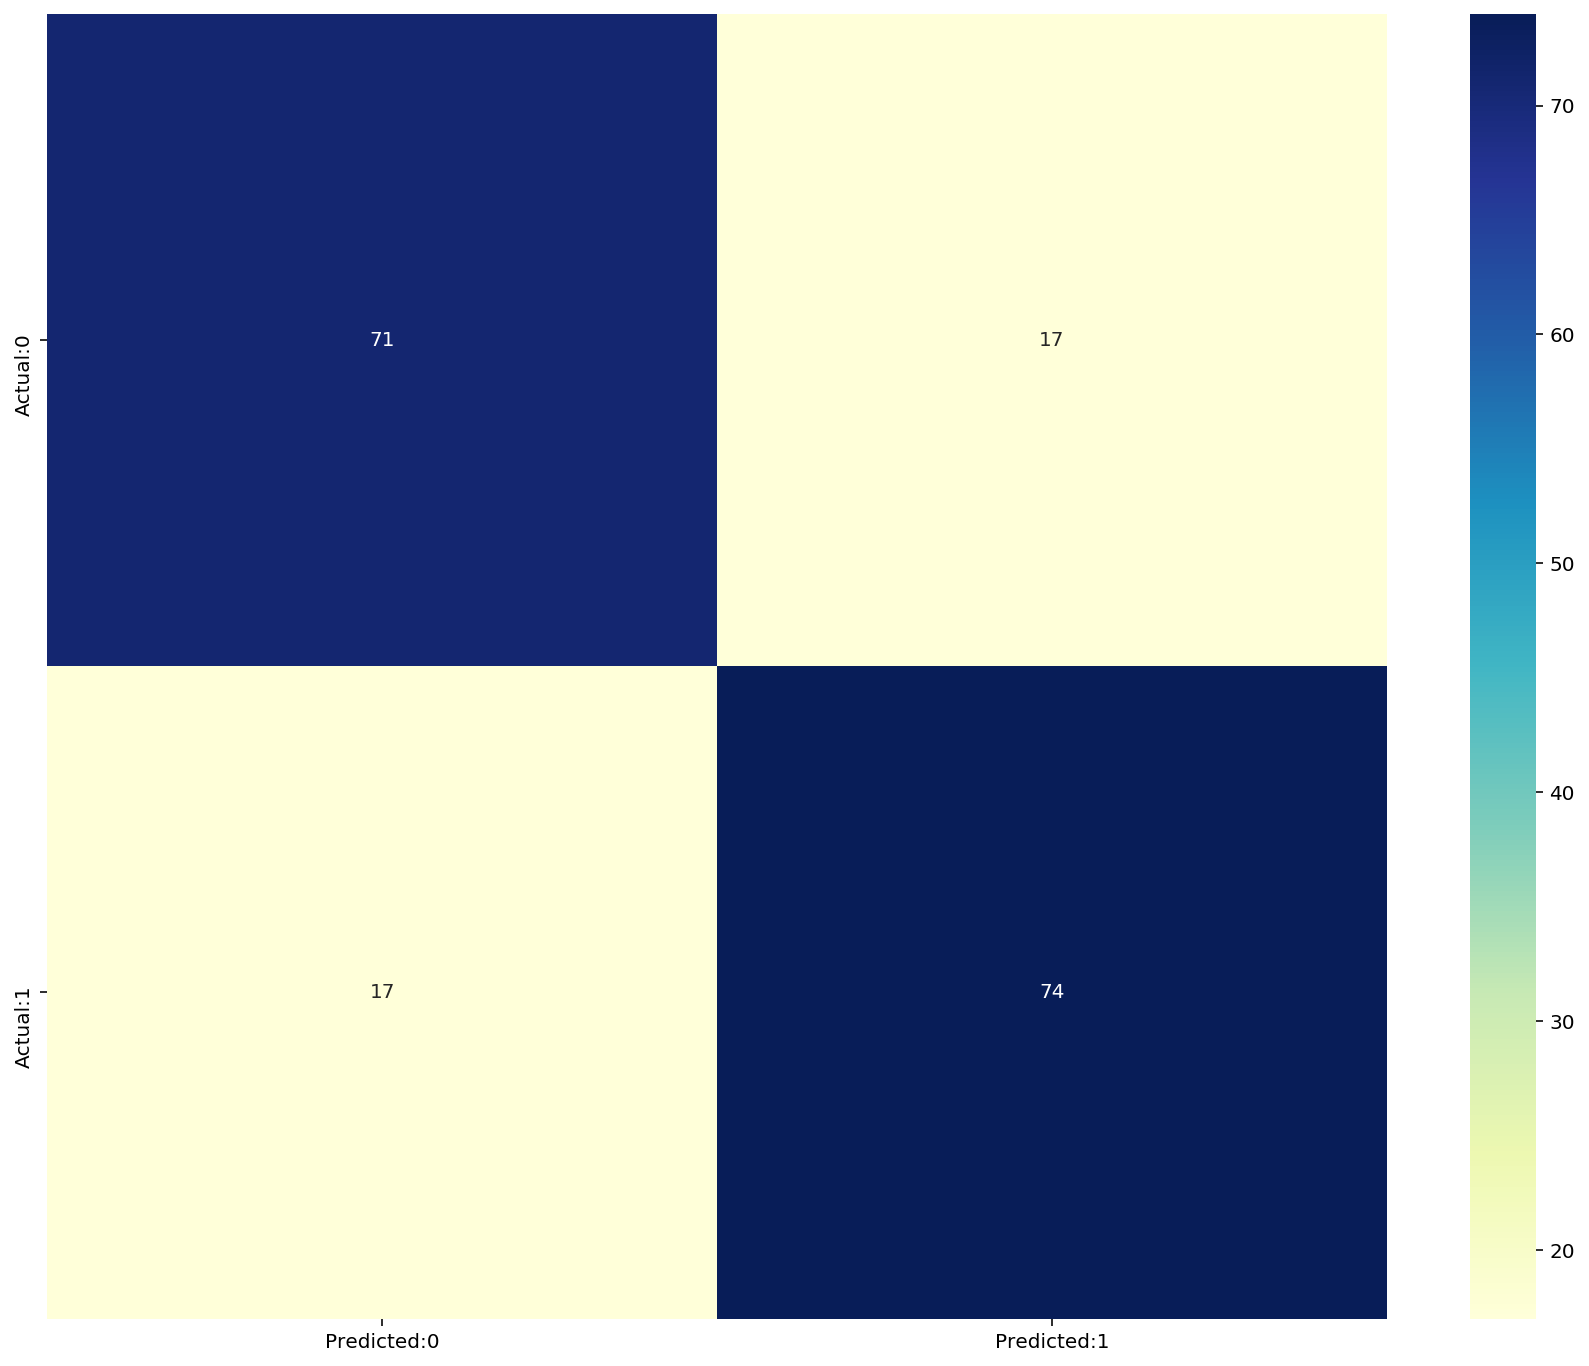

In [68]:
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

## DecisionTree

In [69]:
dc_tr = DecisionTreeClassifier()

In [70]:
dc_tr.fit(X_train, y_train)

DecisionTreeClassifier()

In [71]:
y_pred = dc_tr.predict(X_test)

In [72]:
dctr_f1 = f1_score(y_test, y_pred, average='macro')
dctr_f1

0.7932702812373194

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.82      0.80        88
           1       0.81      0.77      0.79        91

    accuracy                           0.79       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.79      0.79      0.79       179



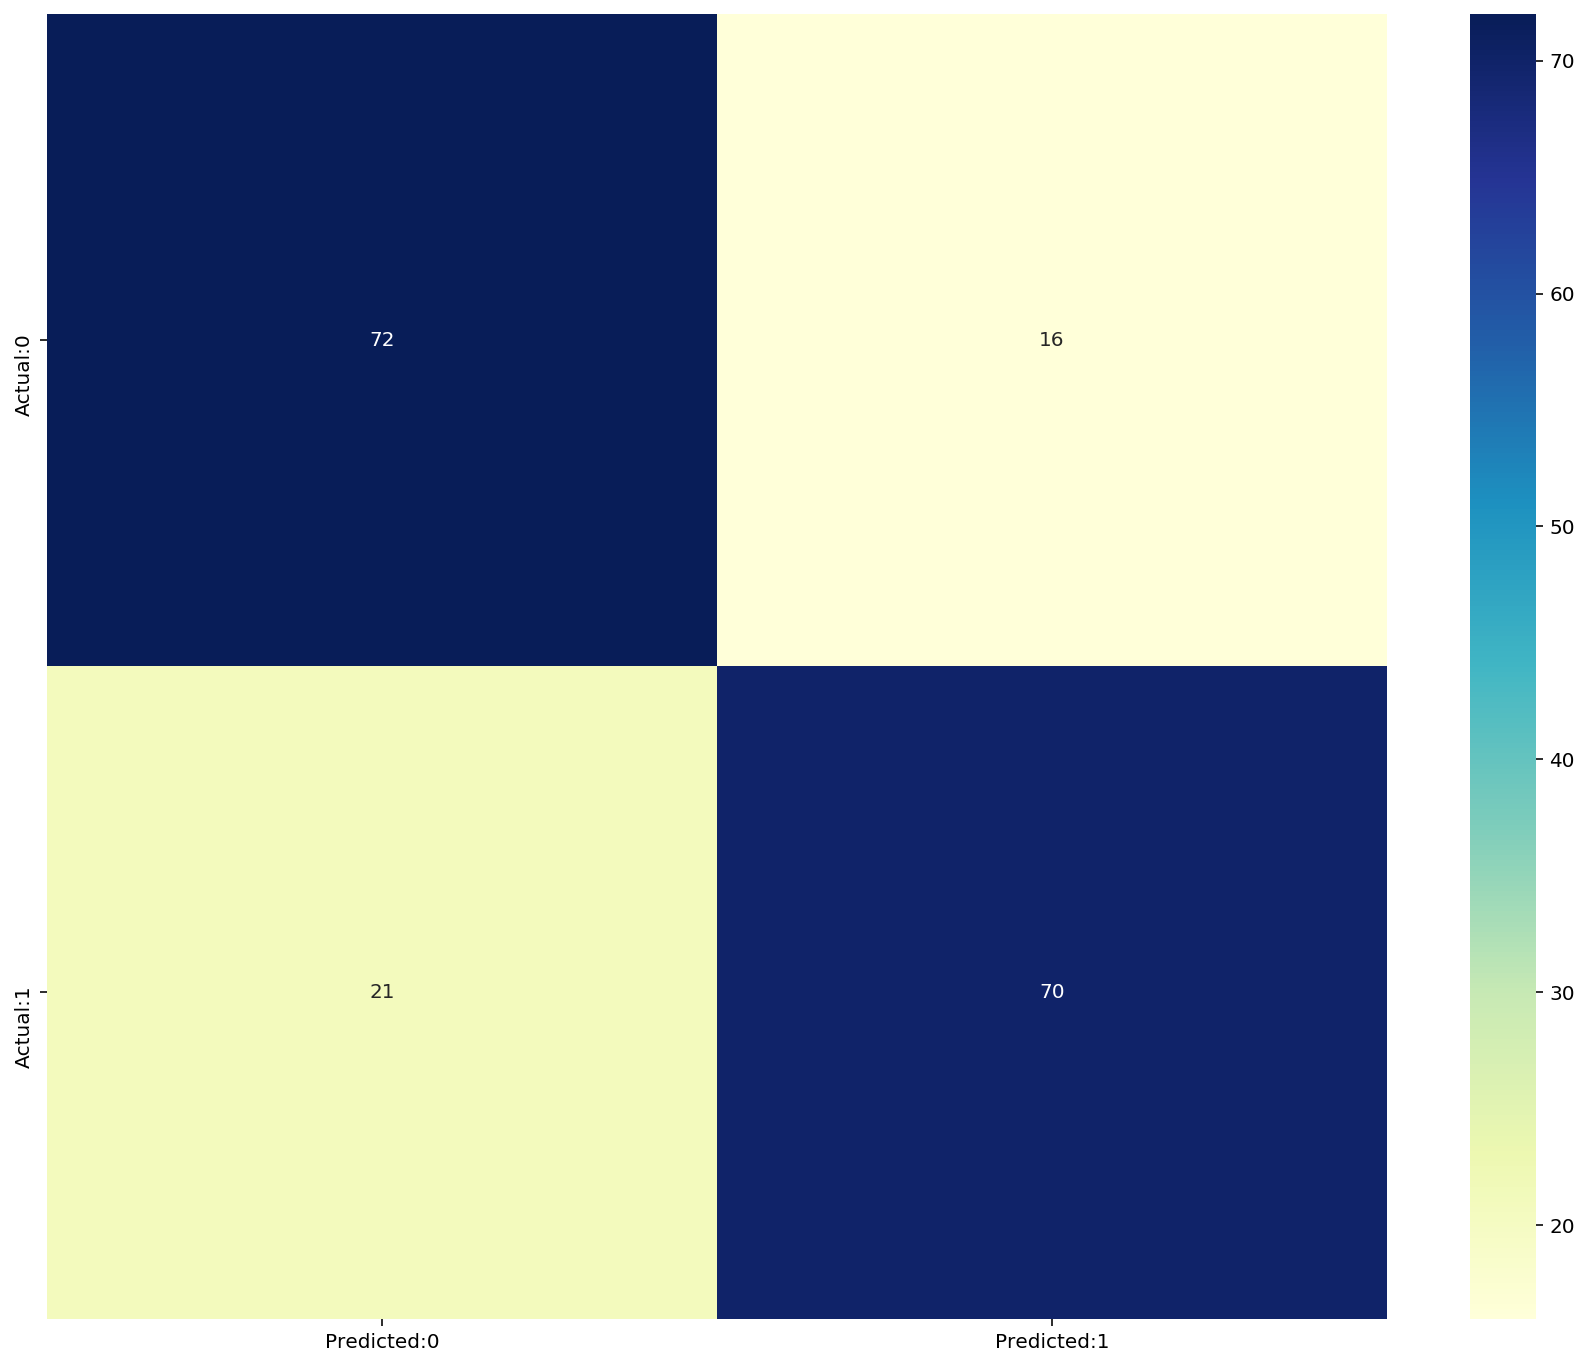

In [74]:
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

## SVM

In [93]:
svc = SVC()

In [94]:
svc.fit(X_train,y_train)

SVC()

In [96]:
y_pred= svc.predict(X_test)

In [97]:
svc_f1 = f1_score(y_test, y_pred, average='macro')
svc_f1

0.8156424581005587

In [98]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82        88
           1       0.83      0.80      0.82        91

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179



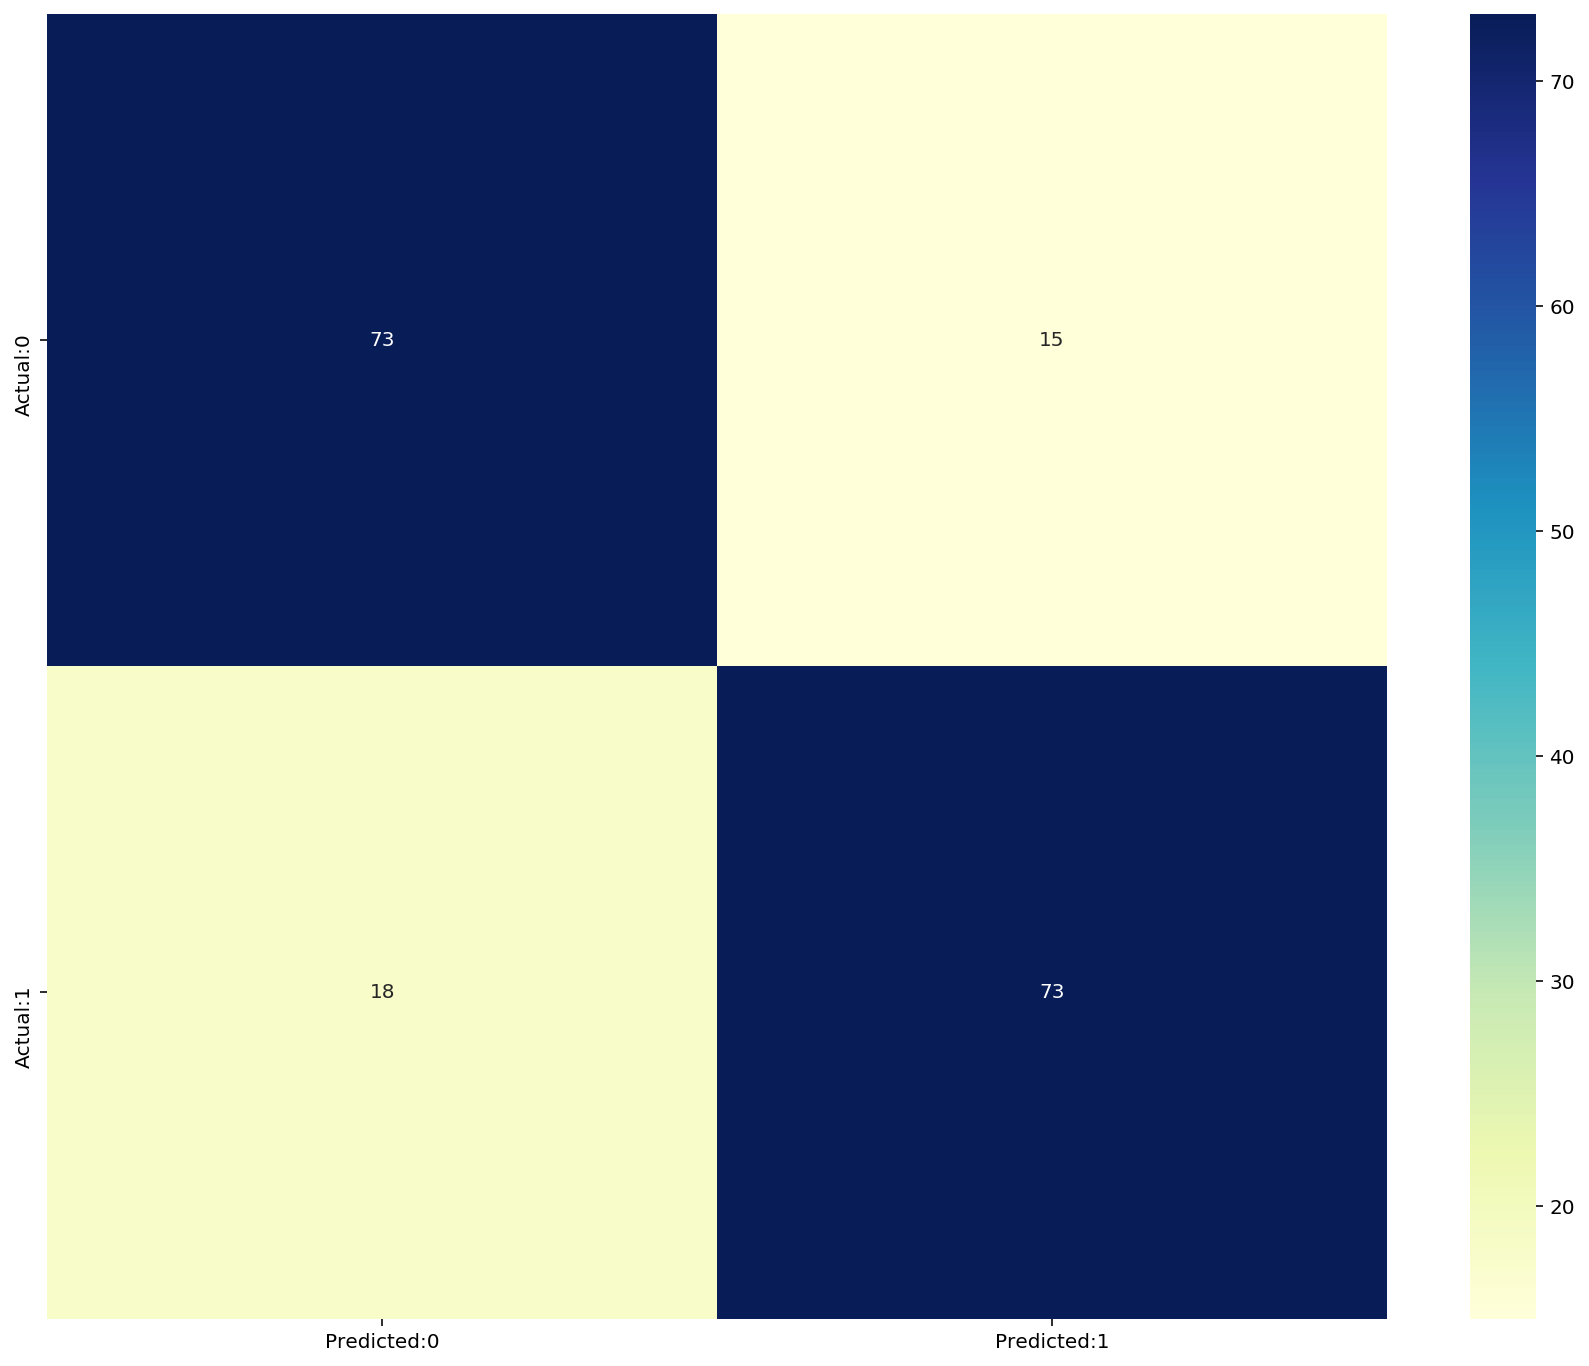

In [99]:
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

In [101]:
scaler = StandardScaler()

In [102]:
X_train_s= scaler.fit_transform(X_train)

In [104]:
X_test_s = scaler.transform(X_test)

In [106]:
svm_model =SVC().fit(X_train_s,y_train)

In [108]:
y_pred=svm_model.predict(X_test_s)

In [109]:
svc_f1_sc = f1_score(y_test, y_pred, average='macro')
svc_f1_sc

0.8156424581005587

In [110]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82        88
           1       0.83      0.80      0.82        91

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179



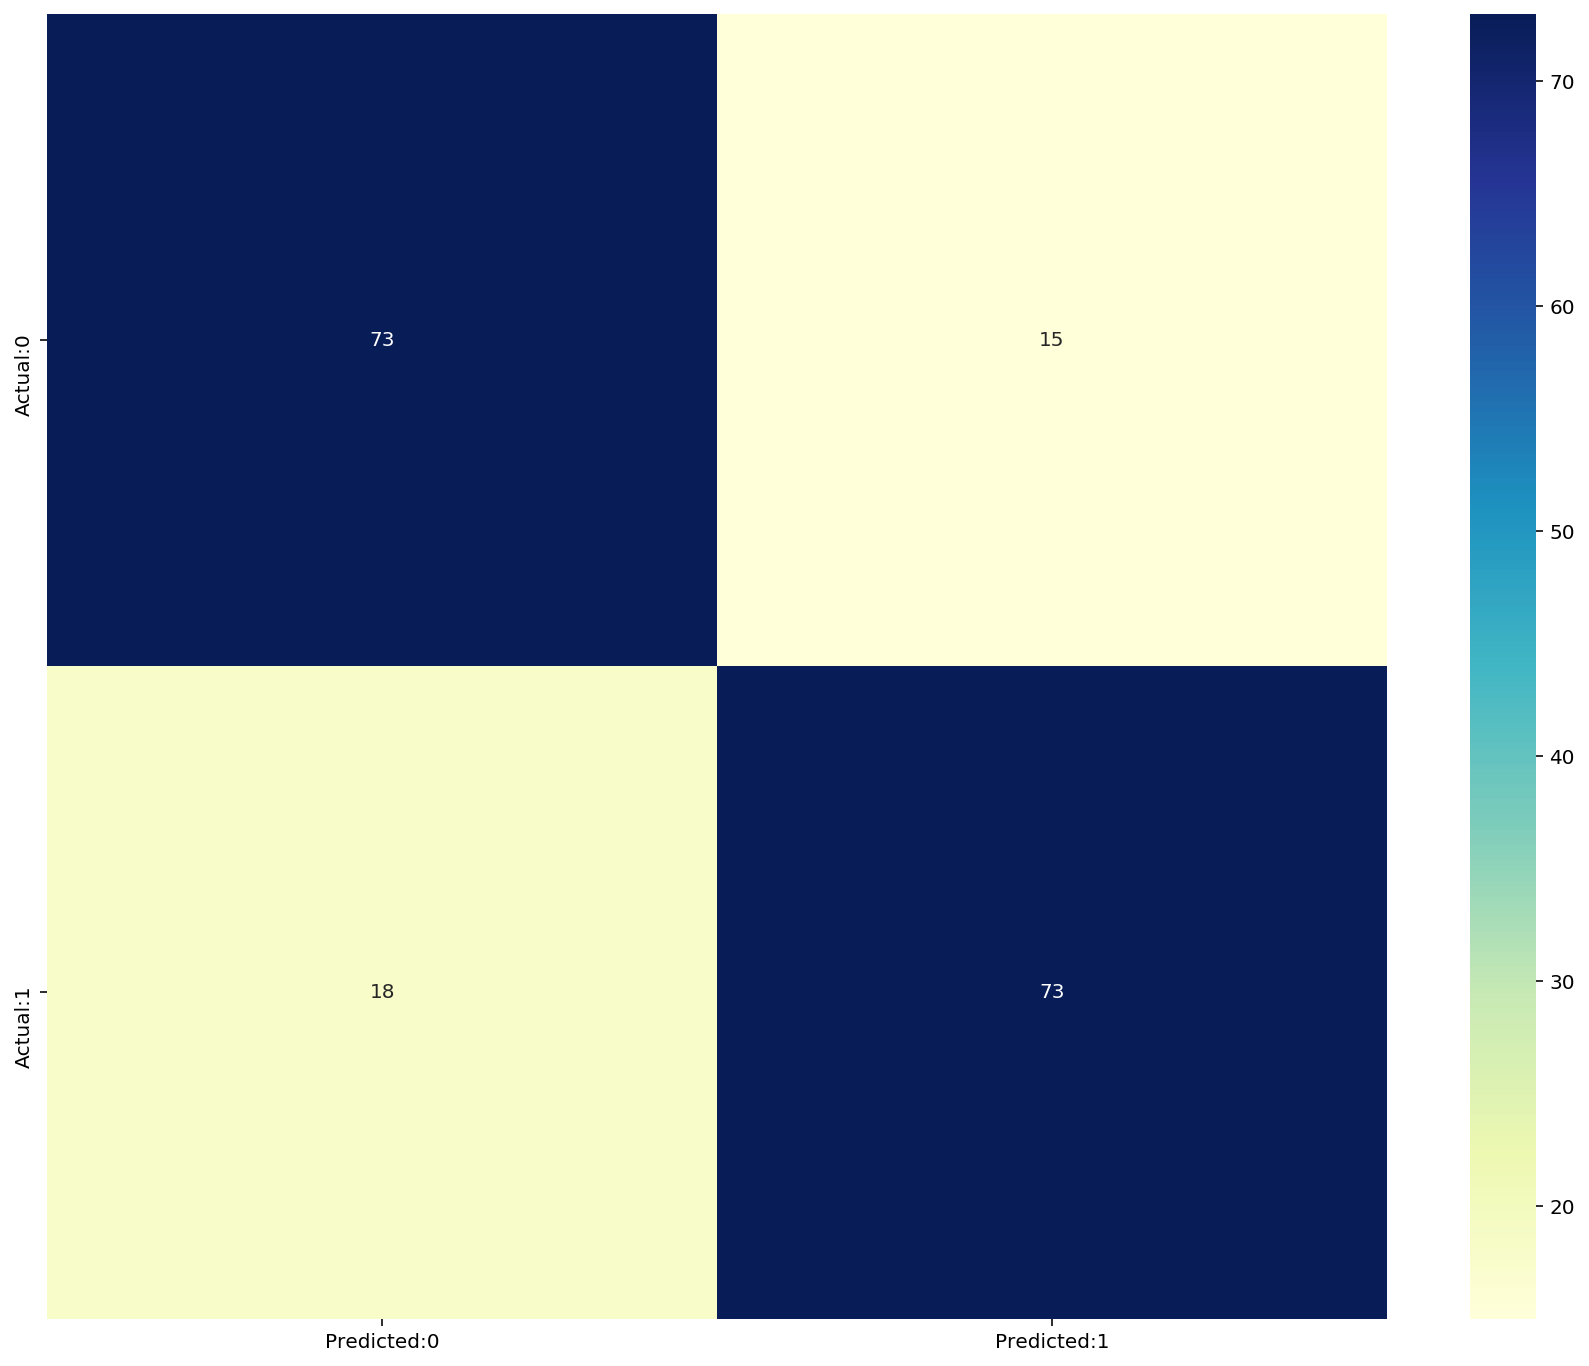

In [111]:
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

## KNN

In [75]:
scaler = StandardScaler()

In [76]:
scaler.fit(df.drop('Target', axis=1))

StandardScaler()

In [77]:
scaled_x = scaler.transform(df.drop('Target', axis=1))

In [78]:
df_scaled = pd.DataFrame(scaled_x, columns=df.columns[:-1])  # convert array to DataFrame

In [79]:
X = df_scaled

In [80]:
y = df['Target']

In [81]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [82]:
def my_accuracy(y_test,y_pred):
    acc = accuracy_score(y_true=y_test, y_pred=y_pred)
    print('Acc: {:.4f}'.format(acc))

In [83]:
def KNN_loop(x_train,y_train,x_test,MAX):
    
    # Loop MAX times
    for i in range(MAX):
        # Create the corresponding KNN Classifier 
        KNeighClf = KNeighborsClassifier(n_neighbors=i+1)
        
        # Fit and predict the model
        KNN = KNeighClf.fit(X_train, y_train)
        y_pred = KNN.predict(X_test)
        
        # Display the results
        # my_confusion_matrix(y_test, y_pred)
        print ("Neighbors = " + str(i+1))
        my_accuracy(y_test,y_pred)

KNN_loop(X_train,y_train,y_test,50)

Neighbors = 1
Acc: 0.8045
Neighbors = 2
Acc: 0.7542
Neighbors = 3
Acc: 0.7765
Neighbors = 4
Acc: 0.7989
Neighbors = 5
Acc: 0.8156
Neighbors = 6
Acc: 0.8212
Neighbors = 7
Acc: 0.8212
Neighbors = 8
Acc: 0.8101
Neighbors = 9
Acc: 0.8156
Neighbors = 10
Acc: 0.7933
Neighbors = 11
Acc: 0.8101
Neighbors = 12
Acc: 0.8045
Neighbors = 13
Acc: 0.8045
Neighbors = 14
Acc: 0.8268
Neighbors = 15
Acc: 0.8101
Neighbors = 16
Acc: 0.8156
Neighbors = 17
Acc: 0.8101
Neighbors = 18
Acc: 0.7933
Neighbors = 19
Acc: 0.7989
Neighbors = 20
Acc: 0.7877
Neighbors = 21
Acc: 0.7821
Neighbors = 22
Acc: 0.7821
Neighbors = 23
Acc: 0.7765
Neighbors = 24
Acc: 0.7877
Neighbors = 25
Acc: 0.7821
Neighbors = 26
Acc: 0.7765
Neighbors = 27
Acc: 0.7821
Neighbors = 28
Acc: 0.7654
Neighbors = 29
Acc: 0.7765
Neighbors = 30
Acc: 0.7821
Neighbors = 31
Acc: 0.7765
Neighbors = 32
Acc: 0.7765
Neighbors = 33
Acc: 0.8045
Neighbors = 34
Acc: 0.7933
Neighbors = 35
Acc: 0.7877
Neighbors = 36
Acc: 0.7765
Neighbors = 37
Acc: 0.7877
Neighbors 

### 14 is best score

In [84]:
# KNN with K=14 seems the best fit
# Run it again with full results this time
KNeighClf = KNeighborsClassifier(14)
KNN = KNeighClf.fit(X_train, y_train)

y_pred = KNN.predict(X_test)

In [85]:
knn_f1 = f1_score(y_test, y_pred, average='macro')
knn_f1

0.8267940194150514

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82        88
           1       0.83      0.82      0.83        91

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



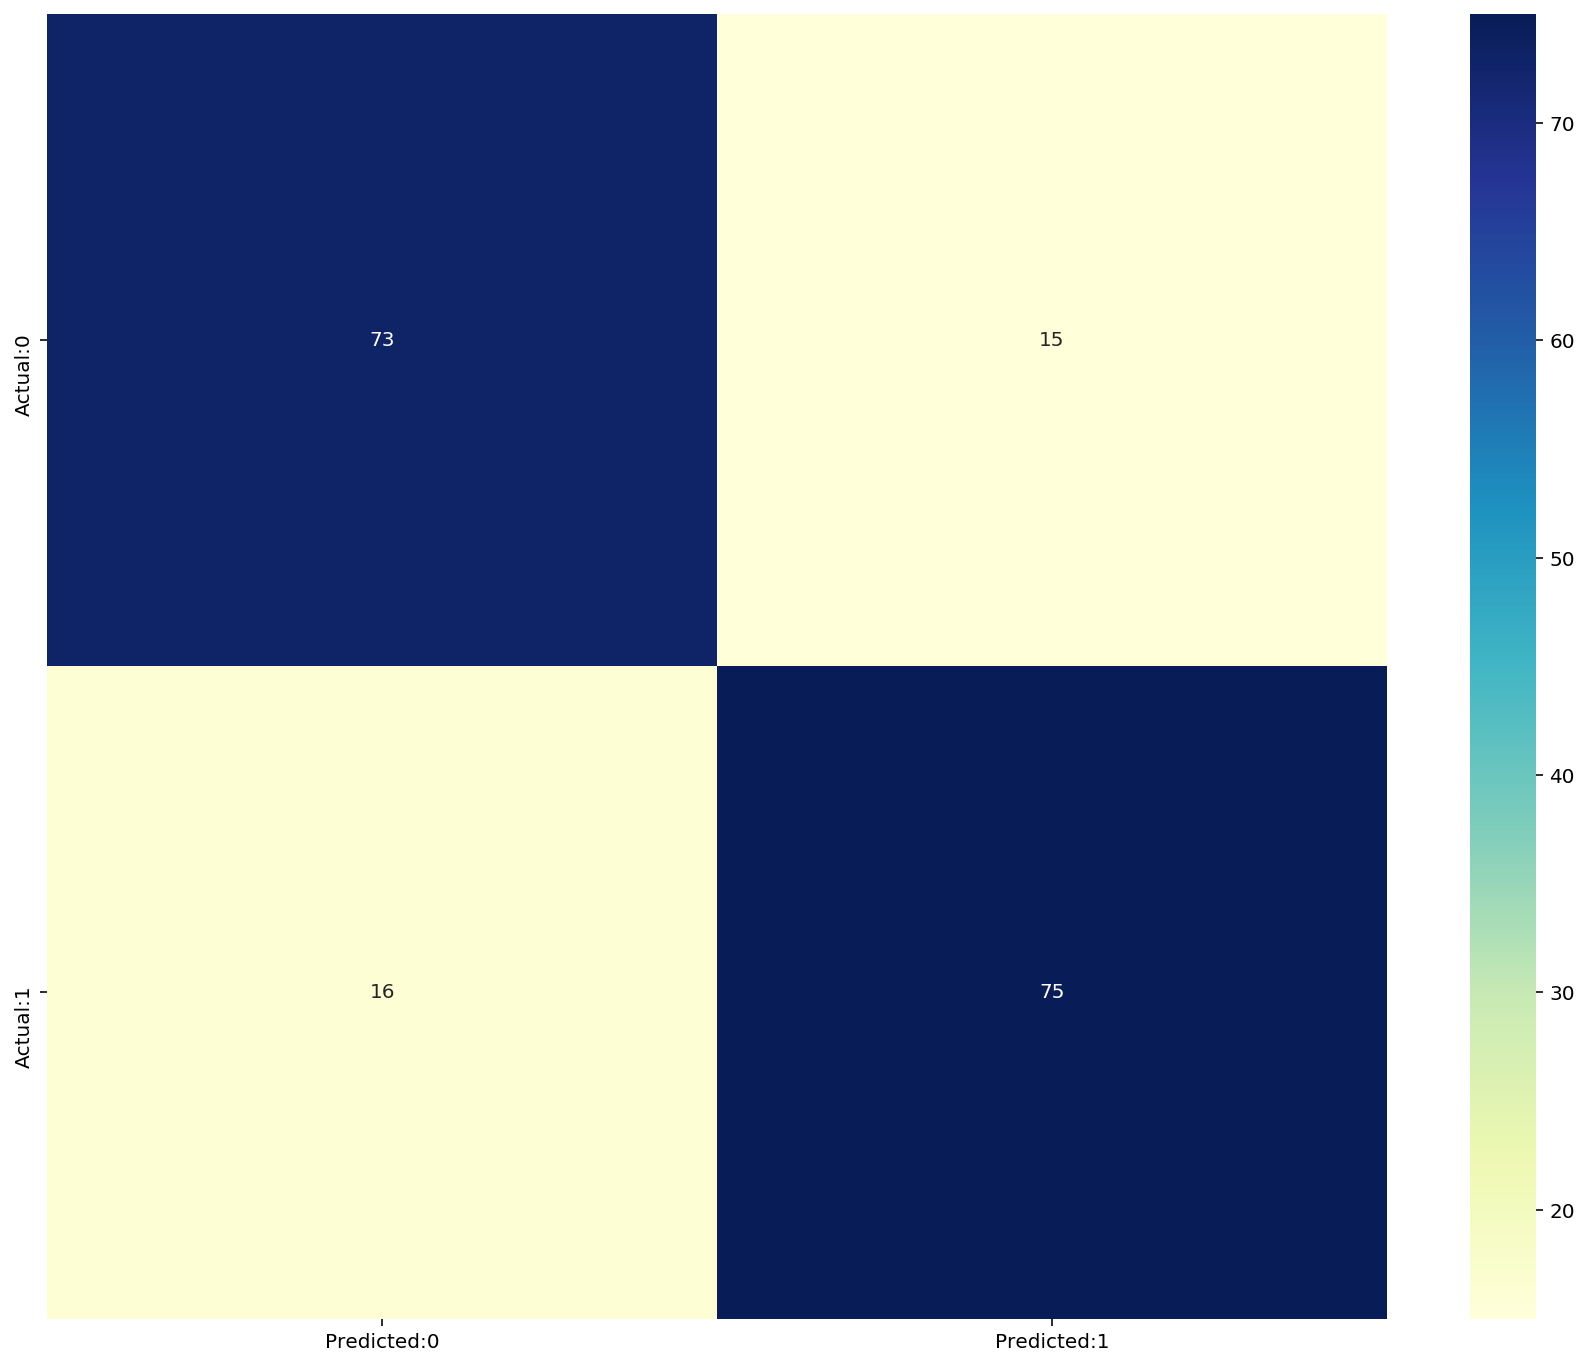

In [87]:
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

# ModelComparison

Text(0.5, 1.0, 'F1 Score of Different Models')

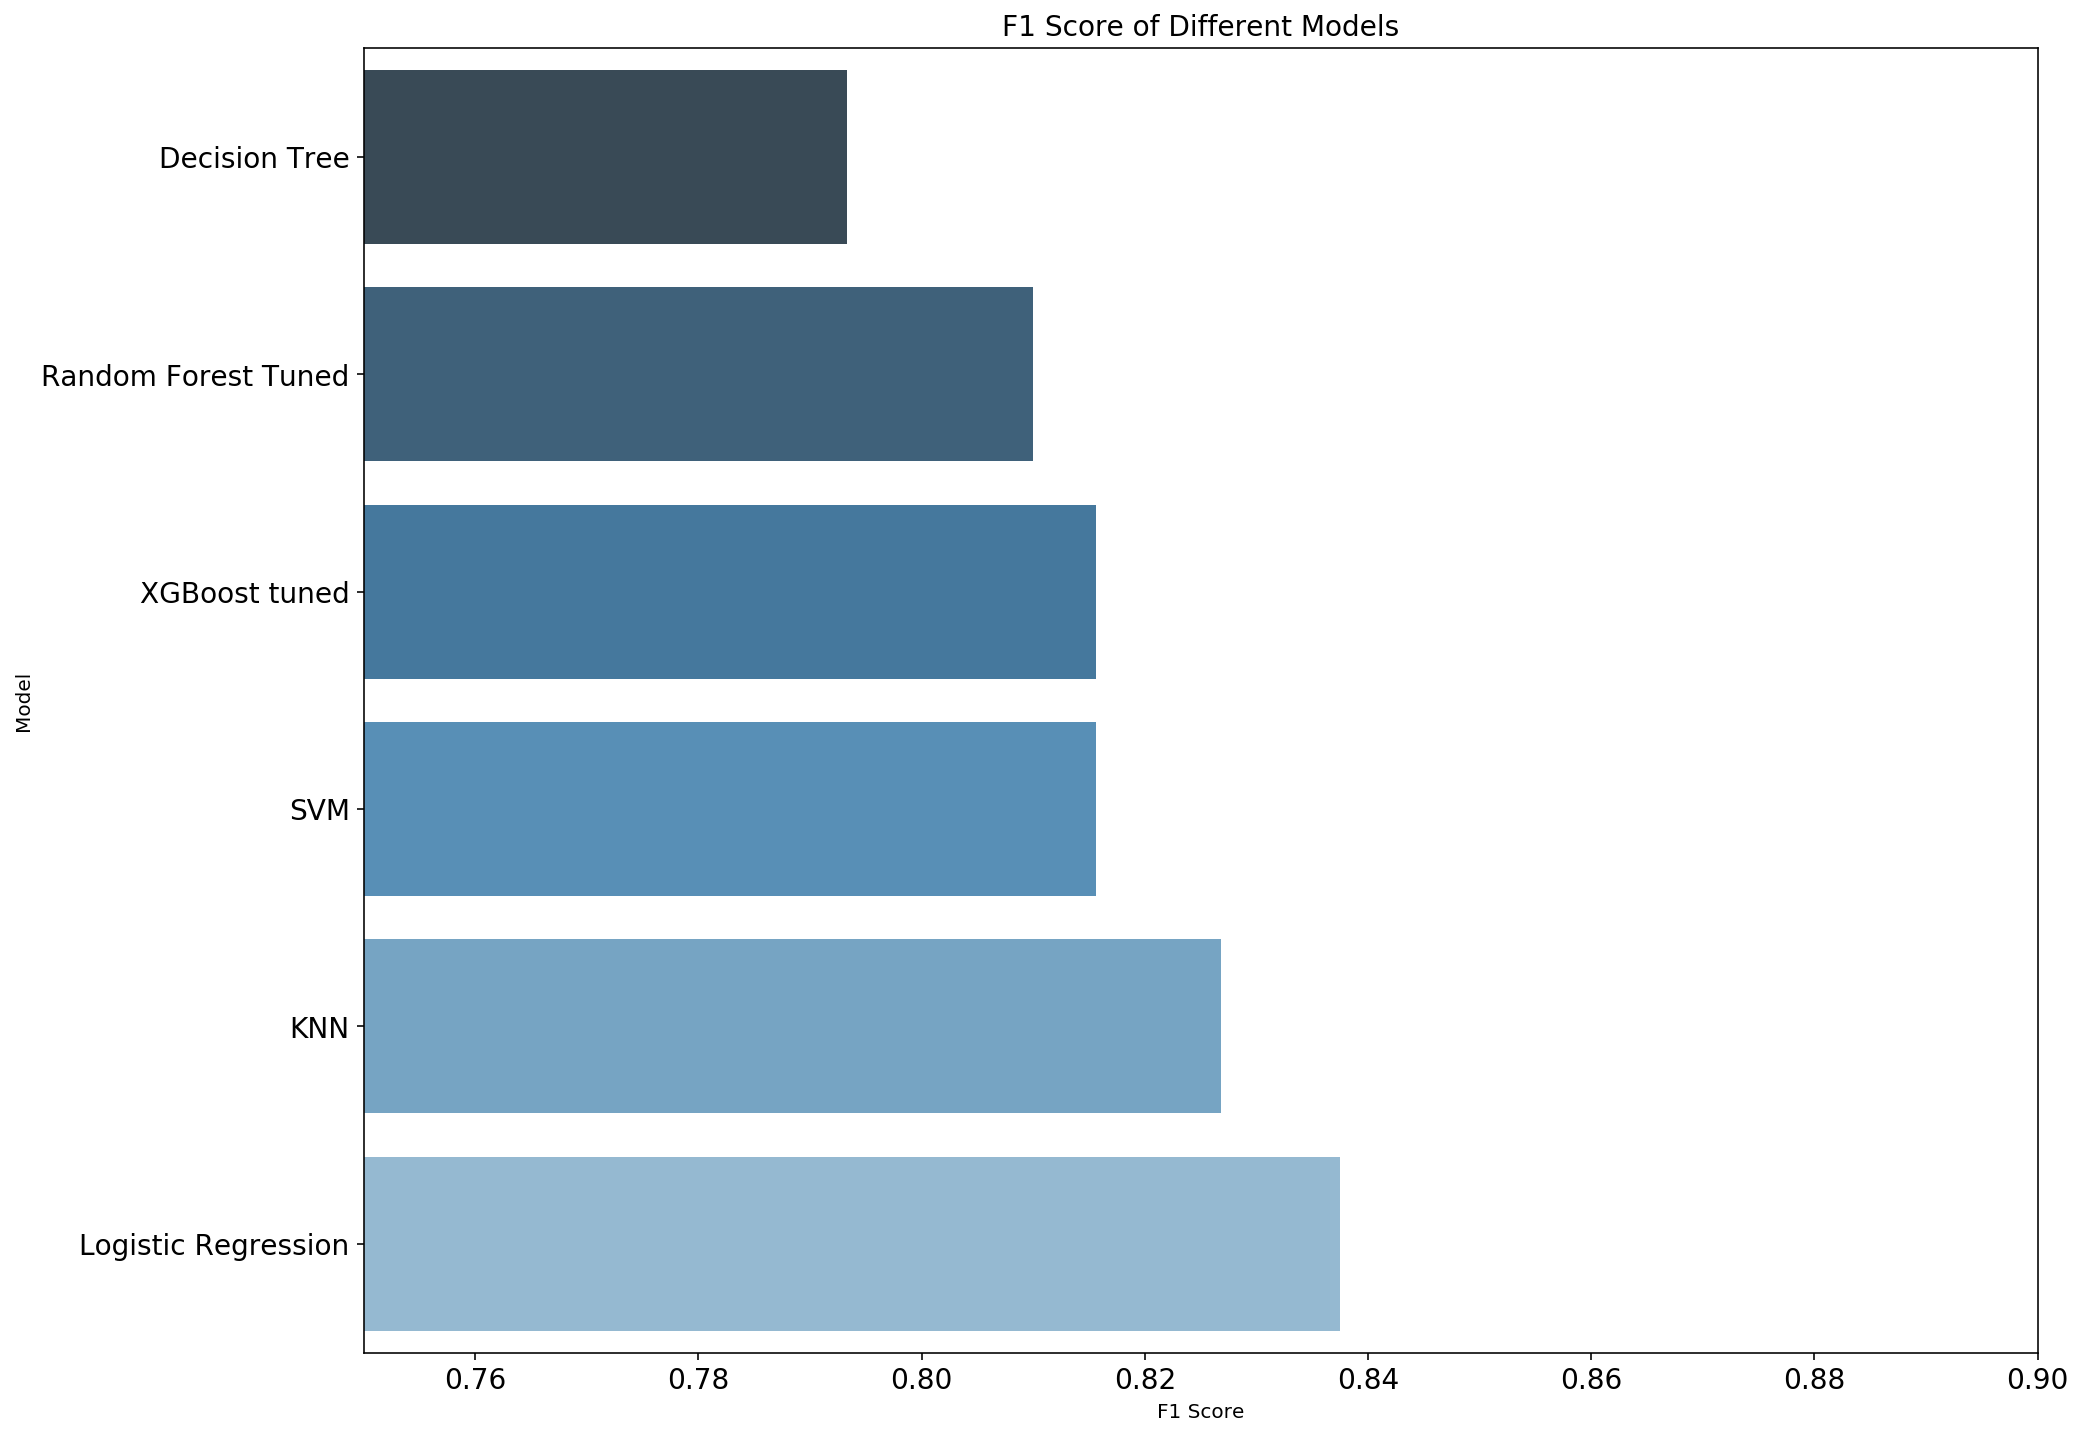

In [112]:
compare = pd.DataFrame({"Model": ["Logistic Regression","XGBoost tuned",
                                  "Random Forest Tuned","Decision Tree", "SVM","KNN"],
                        "F1 Score": [logreg_f1, xgb_f1, rf_f1,dctr_f1,svc_f1_sc,knn_f1]})

compare = compare.sort_values(by="F1 Score", ascending=True)

ax = sns.barplot(x="F1 Score", y="Model", data=compare, palette="Blues_d")
ax.set_xlim(.75, .90)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.title("F1 Score of Different Models", size=14)